In [73]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
from matplotlib import cm
import textwrap
import re

plt.rcParams["font.family"] = "Hiragino Sans"
plt.rcParams["axes.unicode_minus"] = False

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [74]:

# 目的
# ・ハードの売上げに影響の強い（貢献度が高い）と考えられるゲームタイトルの抽出
# ・そのタイトルのハード販売への影響の程度を測る
# ・その影響がタイトルローンチからどの程度継続したか測る（タイトルのハード販売に対する影響度の減衰の程度を測る）

# 利用データ
# 公開されている決算資料。四半期ごとのミリオンセラータイトルと、ハードウェアの販売量（地域別・世界合計）

# 前提と手法
# タイトル数に対して販売データ数（四半期データ数）が少ないので、多重共線性の影響が残る。
# タイトル網羅的な重回帰分析を意図しているわけではないので、説明性を損なわない回帰分析を中心にする。
# 多重共線性に対処する過程で、残すべきタイトルを落としてしまう可能性がある。


In [75]:
df = pd.read_csv("completed_data/merged_data_switch.csv", index_col=0)

df.dropna(subset="FY", inplace=True) # データのある行だけを残す(タイトルの販売量があるときだけ、FYに値が入っているから)
q_dummies = pd.get_dummies(df["Q"].astype(int), prefix="Q", dtype=int, drop_first=True)
df = pd.concat([df, q_dummies], axis=1)
df.head()

,FYQ,FY,Q,あつまれ どうぶつの森,マリオカート8 デラックス,スーパーマリオ 3Dコレクション,リングフィット アドベンチャー,ゼルダの伝説 ブレス オブ ザ ワイルド,大乱闘スマッシュブラザーズ SPECIAL,スーパーマリオパーティ,New スーパーマリオブラザーズU デラックス,ペーパーマリオ オリガミキング,ポケットモンスター ソード・シールド,ゼルダ無双 厄災の黙示録,スーパーマリオ オデッセイ,ルイージマンション3,世界のアソビ大全51,ピクミン3 デラックス,Splatoon2,Xenoblade Definitive Edition,スーパーマリオメーカー2,マリオカート ライブ ホームサーキット,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ,ポケットモンスター スカーレット・バイオレット,Splatoon3,Nintendo Switch Sports,星のカービィ ディスカバリー,マリオパーティ スーパースターズ,マリオストライカーズ バトルリーグ,Pokmon LEGENDS アルセウス,スーパーマリオ 3Dワールド + フューリーワールド,ゼノブレイド3,ファイアーエムブレム エンゲージ,星のカービィ Wii デラックス,メトロイドプライム リマスタード,ベヨネッタ3,ポケットモンスター ブリリアントダイヤモンド・シャイニングパール,ゼルダの伝説 スカイウォードソード HD,メトロイド ドレッド,New ポケモンスナップ,マリオゴルフ スーパーラッシュ,ミートピア,やわらかあたま塾 いっしょにあたまのストレッチ,おすそわける メイド イン ワリオ,ナビつき！ つくってわかる はじめてゲームプログラミング,ARMS,1-2-Switch,ゼノブレイド2,星のカービィ スターアライズ,ポッ拳 ポッケン トーナメント DX,ゼルダの伝説 ティアーズ オブ ザ キングダム,Pikmin 4,ゼルダの伝説 夢をみる島,ファイアーエムブレム 風花雪月,ASTRAL CHAIN,MARVEL ULTIMATE ALLIANCE 3: The Black Order,ゼルダの伝説 知恵のかりもの,ペーパーマリオRPG,ルイージマンション2 HD,スーパー マリオパーティ ジャンボリー,Super Mario Bros. Wonder,マリオ&ルイージRPG ブラザーシップ!,マリオテニス エース,ドンキーコング トロピカルフリーズ,スーパーマリオRPG,プリンセスピーチ Showtime!,マリオvs.ドンキーコング,ドンキーコング リターンズ HD,進め! キノピオ隊長,OCTOPATH TRAVELER,ヨッシークラフトワールド,Nintendo Labo Toy-Con 01: Variety Kit,ルイージマンション３,おすそわける メイド イン ワリオ,ポケモン不思議のダンジョン 救助隊DX,あつまれ どうぶつの森_quarter,マリオカート8 デラックス_quarter,スーパーマリオ 3Dコレクション_quarter,リングフィット アドベンチャー_quarter,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,大乱闘スマッシュブラザーズ SPECIAL_quarter,スーパーマリオパーティ_quarter,New スーパーマリオブラザーズU デラックス_quarter,ペーパーマリオ オリガミキング_quarter,ポケットモンスター ソード・シールド_quarter,ゼルダ無双 厄災の黙示録_quarter,スーパーマリオ オデッセイ_quarter,ルイージマンション3_quarter,世界のアソビ大全51_quarter,ピクミン3 デラックス_quarter,Splatoon2_quarter,Xenoblade Definitive Edition_quarter,スーパーマリオメーカー2_quarter,マリオカート ライブ ホームサーキット_quarter,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter,ポケットモンスター スカーレット・バイオレット_quarter,Splatoon3_quarter,Nintendo Switch Sports_quarter,星のカービィ ディスカバリー_quarter,マリオパーティ スーパースターズ_quarter,マリオストライカーズ バトルリーグ_quarter,Pokmon LEGENDS アルセウス_quarter,スーパーマリオ 3Dワールド + フューリーワールド_quarter,ゼノブレイド3_quarter,ファイアーエムブレム エンゲージ_quarter,星のカービィ Wii デラックス_quarter,メトロイドプライム リマスタード_quarter,ベヨネッタ3_quarter,ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter,ゼルダの伝説 スカイウォードソード HD_quarter,メトロイド ドレッド_quarter,New ポケモンスナップ_quarter,マリオゴルフ スーパーラッシュ_quarter,ミートピア_quarter,やわらかあたま塾 いっしょにあたまのストレッチ_quarter,おすそわける メイド イン ワリオ_quarter,ナビつき！ つくってわかる はじめてゲームプログラミング_quarter,ARMS_quarter,1-2-Switch_quarter,ゼノブレイド2_quarter,星のカービィ スターアライズ_quarter,ポッ拳 ポッケン トーナメント DX_quarter,ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter,Pikmin 4_quarter,ゼルダの伝説 夢をみる島_quarter,ファイアーエムブレム 風花雪月_quarter,ASTRAL CHAIN_quarter,MARVEL ULTIMATE ALLIANCE 3: The Black Order_quarter,ゼルダの伝説 知恵のかりもの_quarter,ペーパーマリオRPG_quarter,ルイージマンション2 HD_quarter,スーパー マリオパーティ ジャンボリー_quarter,Super Mario Bros. Wonder_quarter,マリオ&ルイージRPG ブラザーシップ!_quarter,マリオテニス エース_quarter,ドンキーコング トロピカルフリーズ_quarter,スーパーマリオRPG_quarter,プリンセスピーチ Showtime!_quarter,マリオvs.ドンキーコング_quarter,ドンキーコング リターンズ HD_quarter,進め! キノピオ隊長_quarter,OCTOPATH TRAVELER_quarter,ヨッシークラフトワールド_quarter,Nintendo Labo Toy-Con 01: Variety Kit_quarter,ルイージマンション３_quarter,おすそわける メイド イン ワリオ_quarter,ポケモン不思議のダンジョン 救助隊DX_quarter,Switch_jp_sales,Switch_us_sales,Switch_eur_sales,Switch_others_sales,hard_total_sales,Q_2,Q_3,Q_4
2017-03-31,2017Q4,2017.0,4.0,NaN,NaN,NaN,NaN,276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,120.0,0.0,94.0,274.0,0,0,1
2017-06-30,2018Q1,2018.0,1.0,NaN,354.0,NaN,NaN,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [76]:
df.describe()

,FY,Q,あつまれ どうぶつの森,マリオカート8 デラックス,スーパーマリオ 3Dコレクション,リングフィット アドベンチャー,ゼルダの伝説 ブレス オブ ザ ワイルド,大乱闘スマッシュブラザーズ SPECIAL,スーパーマリオパーティ,New スーパーマリオブラザーズU デラックス,ペーパーマリオ オリガミキング,ポケットモンスター ソード・シールド,ゼルダ無双 厄災の黙示録,スーパーマリオ オデッセイ,ルイージマンション3,世界のアソビ大全51,ピクミン3 デラックス,Splatoon2,Xenoblade Definitive Edition,スーパーマリオメーカー2,マリオカート ライブ ホームサーキット,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ,ポケットモンスター スカーレット・バイオレット,Splatoon3,Nintendo Switch Sports,星のカービィ ディスカバリー,マリオパーティ スーパースターズ,マリオストライカーズ バトルリーグ,Pokmon LEGENDS アルセウス,スーパーマリオ 3Dワールド + フューリーワールド,ゼノブレイド3,ファイアーエムブレム エンゲージ,星のカービィ Wii デラックス,メトロイドプライム リマスタード,ベヨネッタ3,ポケットモンスター ブリリアントダイヤモンド・シャイニングパール,ゼルダの伝説 スカイウォードソード HD,メトロイド ドレッド,New ポケモンスナップ,マリオゴルフ スーパーラッシュ,ミートピア,やわらかあたま塾 いっしょにあたまのストレッチ,おすそわける メイド イン ワリオ,ナビつき！ つくってわかる はじめてゲームプログラミング,ARMS,1-2-Switch,ゼノブレイド2,星のカービィ スターアライズ,ポッ拳 ポッケン トーナメント DX,ゼルダの伝説 ティアーズ オブ ザ キングダム,Pikmin 4,ゼルダの伝説 夢をみる島,ファイアーエムブレム 風花雪月,ASTRAL CHAIN,MARVEL ULTIMATE ALLIANCE 3: The Black Order,ゼルダの伝説 知恵のかりもの,ペーパーマリオRPG,ルイージマンション2 HD,スーパー マリオパーティ ジャンボリー,Super Mario Bros. Wonder,マリオ&ルイージRPG ブラザーシップ!,マリオテニス エース,ドンキーコング トロピカルフリーズ,スーパーマリオRPG,プリンセスピーチ Showtime!,マリオvs.ドンキーコング,ドンキーコング リターンズ HD,進め! キノピオ隊長,OCTOPATH TRAVELER,ヨッシークラフトワールド,Nintendo Labo Toy-Con 01: Variety Kit,ルイージマンション３,おすそわける メイド イン ワリオ,ポケモン不思議のダンジョン 救助隊DX,あつまれ どうぶつの森_quarter,マリオカート8 デラックス_quarter,スーパーマリオ 3Dコレクション_quarter,リングフィット アドベンチャー_quarter,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,大乱闘スマッシュブラザーズ SPECIAL_quarter,スーパーマリオパーティ_quarter,New スーパーマリオブラザーズU デラックス_quarter,ペーパーマリオ オリガミキング_quarter,ポケットモンスター ソード・シールド_quarter,ゼルダ無双 厄災の黙示録_quarter,スーパーマリオ オデッセイ_quarter,ルイージマンション3_quarter,世界のアソビ大全51_quarter,ピクミン3 デラックス_quarter,Splatoon2_quarter,Xenoblade Definitive Edition_quarter,スーパーマリオメーカー2_quarter,マリオカート ライブ ホームサーキット_quarter,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter,ポケットモンスター スカーレット・バイオレット_quarter,Splatoon3_quarter,Nintendo Switch Sports_quarter,星のカービィ ディスカバリー_quarter,マリオパーティ スーパースターズ_quarter,マリオストライカーズ バトルリーグ_quarter,Pokmon LEGENDS アルセウス_quarter,スーパーマリオ 3Dワールド + フューリーワールド_quarter,ゼノブレイド3_quarter,ファイアーエムブレム エンゲージ_quarter,星のカービィ Wii デラックス_quarter,メトロイドプライム リマスタード_quarter,ベヨネッタ3_quarter,ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter,ゼルダの伝説 スカイウォードソード HD_quarter,メトロイド ドレッド_quarter,New ポケモンスナップ_quarter,マリオゴルフ スーパーラッシュ_quarter,ミートピア_quarter,やわらかあたま塾 いっしょにあたまのストレッチ_quarter,おすそわける メイド イン ワリオ_quarter,ナビつき！ つくってわかる はじめてゲームプログラミング_quarter,ARMS_quarter,1-2-Switch_quarter,ゼノブレイド2_quarter,星のカービィ スターアライズ_quarter,ポッ拳 ポッケン トーナメント DX_quarter,ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter,Pikmin 4_quarter,ゼルダの伝説 夢をみる島_quarter,ファイアーエムブレム 風花雪月_quarter,ASTRAL CHAIN_quarter,MARVEL ULTIMATE ALLIANCE 3: The Black Order_quarter,ゼルダの伝説 知恵のかりもの_quarter,ペーパーマリオRPG_quarter,ルイージマンション2 HD_quarter,スーパー マリオパーティ ジャンボリー_quarter,Super Mario Bros. Wonder_quarter,マリオ&ルイージRPG ブラザーシップ!_quarter,マリオテニス エース_quarter,ドンキーコング トロピカルフリーズ_quarter,スーパーマリオRPG_quarter,プリンセスピーチ Showtime!_quarter,マリオvs.ドンキーコング_quarter,ドンキーコング リターンズ HD_quarter,進め! キノピオ隊長_quarter,OCTOPATH TRAVELER_quarter,ヨッシークラフトワールド_quarter,Nintendo Labo Toy-Con 01: Variety Kit_quarter,ルイージマンション３_quarter,おすそわける メイド イン ワリオ_quarter,ポケモン不思議のダンジョン 救助隊DX_quarter,Switch_jp_sales,Switch_us_sales,Switch_eur_sales,Switch_others_sales,hard_total_sales,Q_2,Q_3,Q_4
count,33.000000,33.000000,18.000000,31.000000,3.000000,12.000000,24.000000,20.000000,15.000000,15.000000,3.000000,8.000000,2.000000,20.000000,7.000000,5.000000,2.000000,12.000000,4.000000,6.000000,2.000000,8.00000,7.000000,5.000000,10.00000,6.000000,9.000000,4.000000,4.000000,10.000000,3.000000,1.0,1.0,1.0,2.00000,2.000000,3.000000,2.000000,4.00000,4.000000,4.000000,2.00000,1.0,2.000000,4.000000,1.0,2.00000,3.000000,1.0,5.000000,3.000000,4.000000,3.0,2.000000,2.000000,3.000000,4.000000,4.000000,2.000000,4.000000,2.000000,4.000000,4.000000,2.000000,1.0,1.0,1.0,2.000000,2.000000,1.0,2.00000,4.000000,1.0,1.0,18.000000,31.000000,3.000000,12.000000,24.000000,20.000000,15.000000,15.000000,3.000000,8.000000,2.00000,20.000000,7.000000,5.00000,2.000000,12.000000,4.000000,6.000000,2.000000,8.000000,7.000000,5.000000,10.000000,6.000000,9

In [77]:
# 四半期のみの販売量の説明変数にするために、selected_dfを作成
titles_with_quarter = [col for col in df.columns if "_quarter" in col]
# selected_cols = ["Q_2", "Q_3", "Q_4"] + titles_with_quarter + ["Wii_jp_sales", "Wii_us_sales", "Wii_others_sales" , "hard_total_sales"]
selected_cols = ["Q_2", "Q_3", "Q_4"] + titles_with_quarter + ["hard_total_sales"]
selected_df = df[selected_cols]
selected_df_with_na = selected_df # 欠損処理しないdfを後の分析のために残しておく
selected_df = selected_df.fillna(0)
# selected_df.info()
selected_df.head()

,Q_2,Q_3,Q_4,あつまれ どうぶつの森_quarter,マリオカート8 デラックス_quarter,スーパーマリオ 3Dコレクション_quarter,リングフィット アドベンチャー_quarter,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,大乱闘スマッシュブラザーズ SPECIAL_quarter,スーパーマリオパーティ_quarter,New スーパーマリオブラザーズU デラックス_quarter,ペーパーマリオ オリガミキング_quarter,ポケットモンスター ソード・シールド_quarter,ゼルダ無双 厄災の黙示録_quarter,スーパーマリオ オデッセイ_quarter,ルイージマンション3_quarter,世界のアソビ大全51_quarter,ピクミン3 デラックス_quarter,Splatoon2_quarter,Xenoblade Definitive Edition_quarter,スーパーマリオメーカー2_quarter,マリオカート ライブ ホームサーキット_quarter,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter,ポケットモンスター スカーレット・バイオレット_quarter,Splatoon3_quarter,Nintendo Switch Sports_quarter,星のカービィ ディスカバリー_quarter,マリオパーティ スーパースターズ_quarter,マリオストライカーズ バトルリーグ_quarter,Pokmon LEGENDS アルセウス_quarter,スーパーマリオ 3Dワールド + フューリーワールド_quarter,ゼノブレイド3_quarter,ファイアーエムブレム エンゲージ_quarter,星のカービィ Wii デラックス_quarter,メトロイドプライム リマスタード_quarter,ベヨネッタ3_quarter,ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter,ゼルダの伝説 スカイウォードソード HD_quarter,メトロイド ドレッド_quarter,New ポケモンスナップ_quarter,マリオゴルフ スーパーラッシュ_quarter,ミートピア_quarter,やわらかあたま塾 いっしょにあたまのストレッチ_quarter,おすそわける メイド イン ワリオ_quarter,ナビつき！ つくってわかる はじめてゲームプログラミング_quarter,ARMS_quarter,1-2-Switch_quarter,ゼノブレイド2_quarter,星のカービィ スターアライズ_quarter,ポッ拳 ポッケン トーナメント DX_quarter,ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter,Pikmin 4_quarter,ゼルダの伝説 夢をみる島_quarter,ファイアーエムブレム 風花雪月_quarter,ASTRAL CHAIN_quarter,MARVEL ULTIMATE ALLIANCE 3: The Black Order_quarter,ゼルダの伝説 知恵のかりもの_quarter,ペーパーマリオRPG_quarter,ルイージマンション2 HD_quarter,スーパー マリオパーティ ジャンボリー_quarter,Super Mario Bros. Wonder_quarter,マリオ&ルイージRPG ブラザーシップ!_quarter,マリオテニス エース_quarter,ドンキーコング トロピカルフリーズ_quarter,スーパーマリオRPG_quarter,プリンセスピーチ Showtime!_quarter,マリオvs.ドンキーコング_quarter,ドンキーコング リターンズ HD_quarter,進め! キノピオ隊長_quarter,OCTOPATH TRAVELER_quarter,ヨッシークラフトワールド_quarter,Nintendo Labo Toy-Con 01: Variety Kit_quarter,ルイージマンション３_quarter,おすそわける メイド イン ワリオ_quarter,ポケモン不思議のダンジョン 救助隊DX_quarter,hard_total_sales
2017-03-31,0,0,1,0.0,0.0,0.0,0.0,276.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,274.0
2017-06-30,0,0,0,0.0,354.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.0
2017-09-30,1,0,0,0.0,88.0,0.0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.0
2017-12-31,0,1,0,0.0,291.0,0.0,0.0,201.0,0.0,0.0,0.0,0.0,0.0,0.0,907.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,723.0
2018-03-31,0,0,1,0.0,189.0,0.0,0.0,178.0,0.0,0.0,0.0,0.0,0.0,0.0,134.0,0.0,0.0,0.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,134.0,25.0,126.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.0


In [78]:
def summarize_title_stats(df, title_cols):
    """
    記述統計を見やすく表示する（相関係数、p値付き）
    """
    stats = {}
    for col in title_cols:
        series = df[col].dropna()
        n = series.count()

        # 相関係数とp値の計算（データ数が3以上のときのみ）
        if n > 2:
            corr_val, p_val = pearsonr(df["hard_total_sales"].loc[series.index], series)
            corr_val = round(corr_val, 3)
            p_val = round(p_val, 4)
        else:
            corr_val = None
            p_val = None

        mean_val = series.mean()
        if mean_val != 0:
            cv_val = round(series.std() / mean_val, 3)
        else:
            cv_val = None

        stats[col] = {
            "データ数": n,
            "平均": round(mean_val, 3),
            "中央値": series.median() if n > 0 else None,
            "標準偏差": round(series.std(), 3) if n > 0 else None,
            "最小値": series.min() if n > 0 else None,
            "最大値": series.max() if n > 0 else None,
            "変動係数(CV)": cv_val,
            "相関係数(hard_total_sales)": corr_val,
            "p値(hard_total_sales)": p_val,
            "データ数(再掲)": n,
            "総販売量": series.sum() if n > 0 else None
        }

    summary_df = pd.DataFrame(stats).T
    return summary_df

In [79]:
summary_df = summarize_title_stats(selected_df_with_na, titles_with_quarter)
display(summary_df.sort_values("データ数", ascending=False))

,データ数,平均,中央値,標準偏差,最小値,最大値,変動係数(CV),相関係数(hard_total_sales),p値(hard_total_sales),データ数(再掲),総販売量
マリオカート8 デラックス_quarter,31.0,219.968,181.0,105.269,85.0,462.0,0.479,0.831,0.0000,31.0,6819.0
ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,24.0,132.667,121.5,56.030,24.0,276.0,0.422,0.210,0.3248,24.0,3184.0
スーパーマリオ オデッセイ_quarter,20.0,146.450,110.5,186.181,24.0,907.0,1.271,0.280,0.2319,20.0,2929.0
大乱闘スマッシュブラザーズ SPECIAL_quarter,20.0,181.250,128.5,246.249,36.0,1208.0,1.359,0.387,0.0916,20.0,3625.0
あつまれ どうぶつの森_quarter,18.0,265.722,133.5,332.687,39.0,1177.0,1.252,0.203,0.4201,18.0,4783.0
New スーパーマリオブラザーズU デラックス_quarter,15.0,116.267,125.0,73.238,25.0,331.0,0.630,0.108,0.7022,15.0,1744.0
スーパーマリオパーティ_quarter,15.0,137.733,110.0,119.373,32.0,530.0,0.867,0.464,0.0812,15.0,2066.0
Splatoon2_quarter,12.0,110.917,109.5,87.474,31.0,361.0,0.789,-0.213,0.5068,12.0,1331.0
リングフィット アドベンチャー_quarter,12.0,128.167,116.0,74.693,16.0,284.0,0.583,0.799,0.0018,12.0,1538.0
スーパーマリオ 3Dワールド + フューリーワールド_quarter,10.0,134.800,93.0,153.783,31.0,559.0,1.141,0.116,0.7499,10.0,1348.0


In [80]:
# 分析の信頼度を上げるためにデータ数が一定以上あること、販売量が大きいものでフィルタする。
# 　"データ数" >= 4 のタイトルを残す（とりあえず1年分）

# 例外になりそうなもの（データ数が少なくても販売量が大きいタイトル）
# データ数 3 販売量 901 スーパーマリオ 3Dコレクション
# データ数 2 販売量 1465 スーパーマリオ ポケットモンスター ブリリアントダイヤモンド・シャイニングパール

In [81]:
# データ数でフィルタ
def get_titles_filtered_by_count(summary_df, min_count=4):
    """
    min_count以上のデータ数で記述統計をフィルタして表示
    return: フィルタ後に残ったタイトルのリスト
    """
    filtered_titles_by_count = summary_df[summary_df["データ数"] >= min_count].index.tolist()
    # display(selected_titles)  # 一覧表示
    display(summary_df.loc[filtered_titles_by_count].sort_values("データ数", ascending=False))
    return filtered_titles_by_count

filtered_titles_by_count = get_titles_filtered_by_count(summary_df, min_count=4)
display(filtered_titles_by_count)

,データ数,平均,中央値,標準偏差,最小値,最大値,変動係数(CV),相関係数(hard_total_sales),p値(hard_total_sales),データ数(再掲),総販売量
マリオカート8 デラックス_quarter,31.0,219.968,181.0,105.269,85.0,462.0,0.479,0.831,0.0000,31.0,6819.0
ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,24.0,132.667,121.5,56.030,24.0,276.0,0.422,0.210,0.3248,24.0,3184.0
大乱闘スマッシュブラザーズ SPECIAL_quarter,20.0,181.250,128.5,246.249,36.0,1208.0,1.359,0.387,0.0916,20.0,3625.0
スーパーマリオ オデッセイ_quarter,20.0,146.450,110.5,186.181,24.0,907.0,1.271,0.280,0.2319,20.0,2929.0
あつまれ どうぶつの森_quarter,18.0,265.722,133.5,332.687,39.0,1177.0,1.252,0.203,0.4201,18.0,4783.0
スーパーマリオパーティ_quarter,15.0,137.733,110.0,119.373,32.0,530.0,0.867,0.464,0.0812,15.0,2066.0
New スーパーマリオブラザーズU デラックス_quarter,15.0,116.267,125.0,73.238,25.0,331.0,0.630,0.108,0.7022,15.0,1744.0
Splatoon2_quarter,12.0,110.917,109.5,87.474,31.0,361.0,0.789,-0.213,0.5068,12.0,1331.0
リングフィット アドベンチャー_quarter,12.0,128.167,116.0,74.693,16.0,284.0,0.583,0.799,0.0018,12.0,1538.0
スーパーマリオ 3Dワールド + フューリーワールド_quarter,10.0,134.800,93.0,153.783,31.0,559.0,1.141,0.116,0.7499,10.0,1348.0


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Splatoon3_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'New ポケモンスナップ_quarter',
 'マリオゴルフ スーパーラッシュ_quarter',
 'ミートピア_quarter',
 'ARMS_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'ゼルダの伝説 夢をみる島_quarter',
 'ペーパーマリオRPG_quarter',
 'ルイージマンション2 HD_quarter',
 'Super Mario Bros. Wonder_quarter',
 'マリオテニス エース_quarter',
 'ドンキーコング トロピカルフリーズ_quarter',
 'ルイージマンション３

In [82]:
def simple_OLS(df, y_col: str, X_cols: list):
    y = df[y_col]
    X = df[X_cols]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    res = model.fit()
    print(res.summary())

In [83]:
# 全てのタイトルを説明変数にしてOLS
y_col = "hard_total_sales"
X_cols= [c for c in selected_cols if c != "hard_total_sales"]
simple_OLS(selected_df, y_col, X_cols)

                            OLS Regression Results                            
Dep. Variable:       hard_total_sales   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 15 Nov 2025   Prob (F-statistic):                nan
Time:                        06:33:09   Log-Likelihood:                 886.50
No. Observations:                  33   AIC:                            -1707.
Df Residuals:                       0   BIC:                            -1658.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [84]:
# 説明変数が多すぎて残差自由度が０になっているので、回帰モデルとして使えない

In [85]:
# データ数でフィルタ（>=4）したタイトルを説明変数にしてOLS
simple_OLS(selected_df, y_col, filtered_titles_by_count)

                            OLS Regression Results                            
Dep. Variable:       hard_total_sales   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 15 Nov 2025   Prob (F-statistic):                nan
Time:                        06:33:09   Log-Likelihood:                 859.00
No. Observations:                  33   AIC:                            -1652.
Df Residuals:                       0   BIC:                            -1603.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [86]:
# 多重共線性の確認（VIF）
def compute_vif(df):
    X = df.fillna(0).copy()
    X = sm.add_constant(X, has_constant='add') # 定数項

    
    res = []
    for i in range(1, X.shape[1]):  # const列は除外
        vif_val = variance_inflation_factor(X.values, i)
        res.append({
            "feature": X.columns[i],
            "VIF": vif_val
        })

    res_df = pd.DataFrame(res)
    res_df = res_df.sort_values("VIF", ascending=False).reset_index(drop=True)
    return res_df

In [87]:
print("Variance Inflation Factor")
titlea_for_vif = [col for col in df.columns if "_quarter" in col]
compute_vif(df[titlea_for_vif])

Variance Inflation Factor


/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,あつまれ どうぶつの森_quarter,inf
1,マリオカート8 デラックス_quarter,inf
2,MARVEL ULTIMATE ALLIANCE 3: The Black Order_qu...,inf
3,ASTRAL CHAIN_quarter,inf
4,ファイアーエムブレム 風花雪月_quarter,inf
5,ゼルダの伝説 夢をみる島_quarter,inf
6,Pikmin 4_quarter,inf
7,ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter,inf
8,ポッ拳 ポッケン トーナメント DX_quarter,inf
9,星のカービィ スターアライズ_quarter,inf


In [88]:
# 四半期のデータでは、ローンチ前や飽きられた後に販売量が落ち込んだデータが０になる。そのため、有効なデータの重なりが少なく、vifは無限大。
# vifを取っても、思った以上に参考にならない結果。

In [89]:
# OLS の結果 -> 
# 各タイトルのデータ数が少ない、かつタイトル数が多すぎる。自由度が小さくなって、過学習。
# 四半期ベースのデータので、データ数は増やせない。。。
# このままでは、四半期数に対してタイトル数が多いので、何をしても過学習になる。
# とりあえず、全タイトルを使って、Lasso回帰とRidge回帰とその併用(ElasticNet)をためしてみる。
# その後、データ数でフィルタリングしたタイトルのみで同じ処理をしてみる。

In [ ]:
def _adjusted_r2(r2, n, p_eff):
    """
    調整済R2の計算
    """
    denom = (n - p_eff - 1)  # 残差の自由度
    if denom <= 0:
        return np.nan
    return 1.0 - (1.0 - r2) * (n - 1) / denom

def fit_regularized(
    df, y_col, X_cols,
    kind="elasticnet",
    alphas=None,
    l1_ratios=None,
    random_state=0,
    n_splits=4,
    max_iter=1000000,
    nonzero_threshold=1e-12,  # 非ゼロ判定のしきい値
    scoring="r2", 
):
    """
    df:欠損処理済のdf
    kind: "lasso" or "ridge" or "elasticnet"
    return: 結果のdic
    """
    X = df[X_cols].to_numpy()
    y = df[y_col].to_numpy()
    n_samples, n_features = X.shape

    if alphas is None:
        alphas = np.logspace(-4, 2, 30)
    if kind == "elasticnet" and l1_ratios is None:
        l1_ratios = [0.2, 0.4, 0.5, 0.6, 0.8]

    if kind == "lasso":
        base = Lasso(max_iter=max_iter, random_state=random_state)
        param_grid = {"reg__alpha": alphas}
    elif kind == "ridge":
        base = Ridge(max_iter=max_iter, random_state=random_state)
        param_grid = {"reg__alpha": alphas}
    elif kind == "elasticnet":
        base = ElasticNet(max_iter=max_iter, random_state=random_state)
        param_grid = {"reg__alpha": alphas, "reg__l1_ratio": l1_ratios}
    else:
        raise ValueError('kind は "lasso" / "ridge" / "elasticnet" のいずれか')

    steps = [("scaler", StandardScaler()), ("reg", base)]   
    pipe = Pipeline(steps)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gscv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=tscv,
        scoring=scoring,
        refit=True
    )
    gscv.fit(X, y)

    best_pipe = gscv.best_estimator_
    reg = best_pipe.named_steps["reg"]
    
    y_hat = best_pipe.predict(X) # 予測（in-sample）
    r2 = r2_score(y, y_hat)
    coef = reg.coef_.copy()
    intercept = reg.intercept_

    is_nonzero = np.abs(coef) > nonzero_threshold
    nonzero_features = [f for f, keep in zip(X_cols, is_nonzero) if keep] # 残すべきタイトル
    n_nonzero = len(nonzero_features)
    p_eff = n_nonzero if kind in ("lasso", "elasticnet") else n_features
    adj_r2 = _adjusted_r2(r2, n_samples, p_eff)

    best_alpha = float(getattr(reg, "alpha", np.nan))
    best_l1 = None
    if kind == "elasticnet":
        best_l1 = float(getattr(reg, "l1_ratio", np.nan))
    elif kind == "lasso":
        best_l1 = 1.0  # LassoはL1=1固定

    # 係数を表示
    coef_table = (
        pd.DataFrame({"feature": X_cols, "coef": coef, "abs_coef": np.abs(coef)})
          .sort_values("abs_coef", ascending=False)
          .reset_index(drop=True)
          .drop(columns=["abs_coef"])
    )

    # 情報を表示
    # if kind in ("lasso", "elasticnet"):
    #     print(f"[{kind.upper()}-TS] Non-zero features ({n_nonzero}):")
    #     for f in nonzero_features:
    #         print(f"  - {f}")

    print(f"[{kind.upper()}-TS] n_samples={n_samples}, n_features={n_features}, nonzero={n_nonzero}/{p_eff}  "
          f"alpha={best_alpha:.6g}"
          + (f", l1_ratio={best_l1:.3f}" if best_l1 is not None and not np.isnan(best_l1) else ""))
    print(f"R2={r2:.4f}, Adjusted R2={adj_r2:.4f}, Intercept={intercept:.4f}")

    return {
        "pipeline": best_pipe, 
        "cv": gscv,
        "model": reg,
        "best_alpha": best_alpha,
        "best_l1_ratio": best_l1,
        "r2": r2,
        "adj_r2": adj_r2,
        "nonzero": n_nonzero,
        "nonzero_features": nonzero_features,
        "coef_table": coef_table,
        "y_pred_in_sample": y_hat,
    }

def fit_Lasso(df, y_col: str, X_cols: list, alphas=None, random_state=0, n_splits=4, max_iter=10000, nonzero_threshold=1e-12):
    return fit_regularized(
        df, y_col, X_cols,
        kind="lasso", alphas=alphas,
        random_state=random_state, n_splits=n_splits, max_iter=max_iter, nonzero_threshold=nonzero_threshold
    )

def fit_Ridge(df, y_col: str, X_cols: list, alphas=None, n_splits=4, max_iter=10000, nonzero_threshold=1e-12):
    return fit_regularized(
        df, y_col, X_cols,
        kind="ridge", alphas=alphas,
        n_splits=n_splits, max_iter=max_iter, nonzero_threshold=nonzero_threshold
    )

def fit_ElasticNet(df, y_col: str, X_cols: list, alphas=None, l1_ratios=None, random_state=0, n_splits=4, max_iter=100000, nonzero_threshold=1e-12):
    return fit_regularized(
        df, y_col, X_cols,
        kind="elasticnet", alphas=alphas, l1_ratios=l1_ratios,
        random_state=random_state, n_splits=n_splits, max_iter=max_iter, nonzero_threshold=nonzero_threshold
    )


def compare_all(df, y_col: str, X_cols: list, random_state=0, n_splits=4, max_iter=100000, nonzero_threshold=1e-12):
    """
    3手法を同一条件の時系列CVで学習し、R2/調整済R2/非ゼロ数を比較
    ここでのR2は in-sample。汎化性能は res["cv"].cv_results_ を確認
    return: 結果をまとめたpd.DataFrame
    """
    out = {}
    out["lasso"] = fit_Lasso(df, y_col, X_cols, random_state=random_state, n_splits=n_splits, max_iter=max_iter, nonzero_threshold=nonzero_threshold)
    out["ridge"] = fit_Ridge(df, y_col, X_cols, n_splits=n_splits, max_iter=max_iter, nonzero_threshold=nonzero_threshold)
    out["elasticnet"] = fit_ElasticNet(df, y_col, X_cols, random_state=random_state, n_splits=n_splits, max_iter=max_iter, nonzero_threshold=nonzero_threshold)
    
    def cv_stats(res):
        """GridSearchCVの結果からCV R2の平均と標準偏差を取り出す"""
        mean_cv_r2 = res["cv"].cv_results_["mean_test_score"].max()   # ベストパラメータの平均CV R2
        std_cv_r2  = res["cv"].cv_results_["std_test_score"][res["cv"].cv_results_["mean_test_score"].argmax()] # ベストパラメータのCV R2の標準偏差
        return mean_cv_r2, std_cv_r2

    lasso_cv_mean, lasso_cv_std = cv_stats(out["lasso"])
    ridge_cv_mean, ridge_cv_std = cv_stats(out["ridge"])
    enet_cv_mean, enet_cv_std   = cv_stats(out["elasticnet"])

    summary = pd.DataFrame([
    {
        "model": "Lasso",
        "R2": out["lasso"]["r2"],
        "AdjR2": out["lasso"]["adj_r2"],
        "CV_R2_mean": lasso_cv_mean,
        "CV_R2_std": lasso_cv_std,
        "nonzero": out["lasso"]["nonzero"],
        # "nonzero_titles": ", ".join(out["lasso"]["nonzero_features"])
    },
    {
        "model": "Ridge",
        "R2": out["ridge"]["r2"],
        "AdjR2": out["ridge"]["adj_r2"],
        "CV_R2_mean": ridge_cv_mean,
        "CV_R2_std": ridge_cv_std,
        "nonzero": out["ridge"]["nonzero"],
        # "nonzero_titles": ", ".join(out["ridge"]["nonzero_features"])
    },
    {
        "model": "ElasticNet",
        "R2": out["elasticnet"]["r2"],
        "AdjR2": out["elasticnet"]["adj_r2"],
        "CV_R2_mean": enet_cv_mean,
        "CV_R2_std": enet_cv_std,
        "nonzero": out["elasticnet"]["nonzero"],
        # "nonzero_titles": ", ".join(out["elasticnet"]["nonzero_features"])
    }
])
    print("/// Lasso_nonzero_titles ///")
    display(out["lasso"]["nonzero_features"])
    print("/// Ridge_nonzero_titles ///")
    display(out["ridge"]["nonzero_features"])
    print("/// ElasticNet_nonzero_titles ///")
    display(out["elasticnet"]["nonzero_features"])


    print("\n== compare_all内で実行した結果  R2 AdjR2 は in sample ==")
    return summary

In [91]:
# 試しにLasso, Ridge, elasticnetで単純に全データで比較
compare_with_nonfilterd = compare_all(selected_df, y_col, X_cols=[c for c in X_cols if c not in ['Q_2', 'Q_3', 'Q_4']], max_iter=100000, nonzero_threshold=1e-12)
display(compare_with_nonfilterd)
print("== こここまで 全データでcompare_all ==")

[LASSO-TS] n_samples=33, n_features=72, nonzero=68/68  alpha=0.000417532, l1_ratio=1.000
R2=1.0000, Adjusted R2=nan, Intercept=453.8182
[RIDGE-TS] n_samples=33, n_features=72, nonzero=72/72  alpha=14.8735
R2=0.9848, Adjusted R2=nan, Intercept=453.8182
[ELASTICNET-TS] n_samples=33, n_features=72, nonzero=72/72  alpha=0.000161026, l1_ratio=0.600
R2=1.0000, Adjusted R2=nan, Intercept=453.8182
/// Lasso_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'スーパーマリオ 3Dコレクション_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ペーパーマリオ オリガミキング_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'ゼルダ無双 厄災の黙示録_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'ピクミン3 デラックス_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 'マリオカート ライブ ホームサーキット_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Splatoon3_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'ゼノブレイド3_quarter',
 'ファイアーエムブレム エンゲージ_quarter',
 'ベヨネッタ3_quarter',
 'ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter',
 'ゼルダの伝説 スカイウォードソード HD_quarter',
 'メトロイド ドレッド_qua

/// Ridge_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'スーパーマリオ 3Dコレクション_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ペーパーマリオ オリガミキング_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'ゼルダ無双 厄災の黙示録_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'ピクミン3 デラックス_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 'マリオカート ライブ ホームサーキット_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Splatoon3_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'ゼノブレイド3_quarter',
 'ファイアーエムブレム エンゲージ_quarter',
 '星のカービィ Wii デラックス_quarter',
 'メトロイドプライム リマスタード_quarter',
 'ベヨネッタ3_quarter',
 'ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_q

/// ElasticNet_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'スーパーマリオ 3Dコレクション_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ペーパーマリオ オリガミキング_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'ゼルダ無双 厄災の黙示録_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'ピクミン3 デラックス_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 'マリオカート ライブ ホームサーキット_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Splatoon3_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'ゼノブレイド3_quarter',
 'ファイアーエムブレム エンゲージ_quarter',
 '星のカービィ Wii デラックス_quarter',
 'メトロイドプライム リマスタード_quarter',
 'ベヨネッタ3_quarter',
 'ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_q


== compare_all内で実行した結果  R2 AdjR2 は in sample ==


,model,R2,AdjR2,CV_R2_mean,CV_R2_std,nonzero
0,Lasso,1.000000,NaN,0.522935,0.215023,68
1,Ridge,0.984758,NaN,0.157663,0.266306,72
2,ElasticNet,1.000000,NaN,0.523061,0.215037,72


== こここまで 全データでcompare_all ==


In [92]:
# 結果 -> 
# OLSと同じく、タイトル数が四半期数に比べて多いので分析できない
# lassoでも過学習

In [93]:
# データ数4でフィルタしたタイトルでcompare_all
compare_filtered_by_count = compare_all(selected_df, y_col, filtered_titles_by_count, max_iter=100000, nonzero_threshold=1e-12)
display(compare_filtered_by_count)
print("== ここまで データ数4 でフィルタしてcompare_all ==")
# display(filtered_titles_by_count)

[LASSO-TS] n_samples=33, n_features=35, nonzero=7/7  alpha=23.9503, l1_ratio=1.000
R2=0.8790, Adjusted R2=0.8451, Intercept=453.8182
[RIDGE-TS] n_samples=33, n_features=35, nonzero=35/35  alpha=14.8735
R2=0.9313, Adjusted R2=nan, Intercept=453.8182
[ELASTICNET-TS] n_samples=33, n_features=35, nonzero=33/33  alpha=3.56225, l1_ratio=0.800
R2=0.8826, Adjusted R2=nan, Intercept=453.8182
/// Lasso_nonzero_titles ///


['マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'スーパーマリオパーティ_quarter',
 'スーパーマリオ オデッセイ_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ARMS_quarter']

/// Ridge_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Splatoon3_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'New ポケモンスナップ_quarter',
 'マリオゴルフ スーパーラッシュ_quarter',
 'ミートピア_quarter',
 'ARMS_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'ゼルダの伝説 夢をみる島_quarter',
 'ペーパーマリオRPG_quarter',
 'ルイージマンション2 HD_quarter',
 'Super Mario Bros. Wonder_quarter',
 'マリオテニス エース_quarter',
 'ドンキーコング トロピカルフリーズ_quarter',
 'ルイージマンション３

/// ElasticNet_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'New ポケモンスナップ_quarter',
 'マリオゴルフ スーパーラッシュ_quarter',
 'ミートピア_quarter',
 'ARMS_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'ゼルダの伝説 夢をみる島_quarter',
 'ペーパーマリオRPG_quarter',
 'ルイージマンション2 HD_quarter',
 'Super Mario Bros. Wonder_quarter',
 'マリオテニス エース_quarter',
 'ドンキーコング トロピカルフリーズ_quarter',
 'ルイージマンション３_quarter']


== compare_all内で実行した結果  R2 AdjR2 は in sample ==


,model,R2,AdjR2,CV_R2_mean,CV_R2_std,nonzero
0,Lasso,0.878968,0.845079,0.373799,0.526196,7
1,Ridge,0.931267,NaN,0.368516,0.239189,35
2,ElasticNet,0.882563,NaN,0.381214,0.236403,33


== ここまで データ数4 でフィルタしてcompare_all ==


In [94]:
# lassoで特徴量が７まで減ってもCV_R2が上がらないのは、データ数（四半期数）が少なさが原因の可能性が高い
# CV_R2の分散が0.5と大きいのは、タイトル販売のデータに季節性のスパイクや多重共線性の影響が強く出ているからと考えられる
# ridgeとelasticnetは自由度不足（まだタイトル数が多い）

# ここからさらに諸条件でタイトルをフィルタ
# フィルタ条件
# ・販売量
# ・季節性調整後の相関
# ・データ数 > 8

# 同時に販売されている人気タイトルは多重共線性の原因になるが、同時期に同じように売れたタイトルはデータ上の差別化はできず、個別の影響度は測りにくい。
# フィルタしても、同じ時期に同じように良く売れたタイトルは残る。
# -> 特徴量がすべて「タイトルの販売量」という同じ性質である以上、多重共線性の問題は残る。

In [95]:
# 販売量でフィルタ
def culc_total_sales(df):
    """
    return: タイトルと販売量の総計のpd.DataFrame
    """
    title_cols = [title for title in df.columns if "_quarter" in title]
    total_sales_df = df[title_cols].sum()
    total_sales_df = total_sales_df.reset_index()
    total_sales_df.columns = ["title", "total_sales"]
    total_sales_df = total_sales_df.sort_values(by="total_sales", ascending=False).reset_index(drop=True)
    # display(total_sales_df)
    return total_sales_df

def get_titles_filtered_by_sales(total_sales_df, min_sales=1000):
    """
    min_sales以上のデータ数で記述統計をフィルタして表示
    return: フィルタ後に残ったタイトルのリスト
    """
    sample_size = len(total_sales_df)
    print(f"sample_size: {sample_size}")
    print(f"残すものは、販売量 >{min_sales}万本 でフィルタ")
    filtered_df_by_sales = total_sales_df[total_sales_df["total_sales"] > min_sales]["title"].tolist()
    # filtered_titles = filtered_df_by_sales["title"].tolist()
    return filtered_df_by_sales

In [96]:
# タイトルの販売量 > 1000万本でフィルタしたタイトルでcompare_all
total_sales_df = culc_total_sales(selected_df)
print(f"total_sales_df: {len(total_sales_df)}")
titles_filtered_by_sales = get_titles_filtered_by_sales(total_sales_df, min_sales=1000)
y_col = "hard_total_sales"
# X_cols_titles_filtered_by_sales = ["Q_2", "Q_3", "Q_4"] + titles_filtered_by_sales
compare_filtered_by_sales = compare_all(selected_df, y_col, titles_filtered_by_sales, max_iter=1000000, nonzero_threshold=1e-12)
display(compare_filtered_by_sales)
display(titles_filtered_by_sales)

total_sales_df: 72
sample_size: 72
残すものは、販売量 >1000万本 でフィルタ
[LASSO-TS] n_samples=33, n_features=22, nonzero=6/6  alpha=38.5662, l1_ratio=1.000
R2=0.8093, Adjusted R2=0.7653, Intercept=453.8182
[RIDGE-TS] n_samples=33, n_features=22, nonzero=22/22  alpha=9.23671
R2=0.9251, Adjusted R2=0.7603, Intercept=453.8182
[ELASTICNET-TS] n_samples=33, n_features=22, nonzero=22/22  alpha=1.37382, l1_ratio=0.600
R2=0.8900, Adjusted R2=0.6481, Intercept=453.8182
/// Lasso_nonzero_titles ///


['マリオカート8 デラックス_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'スーパーマリオパーティ_quarter',
 'リングフィット アドベンチャー_quarter',
 'ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter']

/// Ridge_nonzero_titles ///


['マリオカート8 デラックス_quarter',
 'あつまれ どうぶつの森_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'Nintendo Switch Sports_quarter',
 'Super Mario Bros. Wonder_quarter',
 'リングフィット アドベンチャー_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'マリオパーティ スーパースターズ_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'Splatoon2_quarter',
 'ルイージマンション3_quarter',
 'Splatoon3_quarter',
 'ルイージマンション３_quarter']

/// ElasticNet_nonzero_titles ///


['マリオカート8 デラックス_quarter',
 'あつまれ どうぶつの森_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'Nintendo Switch Sports_quarter',
 'Super Mario Bros. Wonder_quarter',
 'リングフィット アドベンチャー_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'マリオパーティ スーパースターズ_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'Splatoon2_quarter',
 'ルイージマンション3_quarter',
 'Splatoon3_quarter',
 'ルイージマンション３_quarter']


== compare_all内で実行した結果  R2 AdjR2 は in sample ==


,model,R2,AdjR2,CV_R2_mean,CV_R2_std,nonzero
0,Lasso,0.809327,0.765325,0.342725,0.489400,6
1,Ridge,0.925109,0.760349,0.363185,0.280902,22
2,ElasticNet,0.890028,0.648089,0.360152,0.301874,22


['マリオカート8 デラックス_quarter',
 'あつまれ どうぶつの森_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'Nintendo Switch Sports_quarter',
 'Super Mario Bros. Wonder_quarter',
 'リングフィット アドベンチャー_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'マリオパーティ スーパースターズ_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'Splatoon2_quarter',
 'ルイージマンション3_quarter',
 'Splatoon3_quarter',
 'ルイージマンション３_quarter']

In [97]:
# 販売量>1000でフィルタした記述統計
display(summary_df[summary_df["総販売量"]>1000].sort_values("総販売量", ascending=False))

,データ数,平均,中央値,標準偏差,最小値,最大値,変動係数(CV),相関係数(hard_total_sales),p値(hard_total_sales),データ数(再掲),総販売量
マリオカート8 デラックス_quarter,31.0,219.968,181.0,105.269,85.0,462.0,0.479,0.831,0.0000,31.0,6819.0
あつまれ どうぶつの森_quarter,18.0,265.722,133.5,332.687,39.0,1177.0,1.252,0.203,0.4201,18.0,4783.0
大乱闘スマッシュブラザーズ SPECIAL_quarter,20.0,181.250,128.5,246.249,36.0,1208.0,1.359,0.387,0.0916,20.0,3625.0
ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,24.0,132.667,121.5,56.030,24.0,276.0,0.422,0.210,0.3248,24.0,3184.0
スーパーマリオ オデッセイ_quarter,20.0,146.450,110.5,186.181,24.0,907.0,1.271,0.280,0.2319,20.0,2929.0
ポケットモンスター スカーレット・バイオレット_quarter,7.0,382.714,113.0,741.204,41.0,2061.0,1.937,0.712,0.0726,7.0,2679.0
ポケットモンスター ソード・シールド_quarter,8.0,303.500,132.0,527.944,38.0,1606.0,1.740,0.335,0.4179,8.0,2428.0
ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter,5.0,434.600,99.0,792.359,33.0,1851.0,1.823,0.127,0.8382,5.0,2173.0
スーパーマリオパーティ_quarter,15.0,137.733,110.0,119.373,32.0,530.0,0.867,0.464,0.0812,15.0,2066.0
New スーパーマリオブラザーズU デラックス_quarter,15.0,116.267,125.0,73.238,25.0,331.0,0.630,0.108,0.7022,15.0,1744.0


In [98]:
# 改善しているように見えるが、elasticnetでは、max_iter=1000000で収束
# lassoのCV_R2_meanとCV_R2_stdの値が改善している -> 販売量でフィルタしたことでノイズを持ったタイトルが取り除かれた。データ数>4でのフィルタでは、販売量の小さなタイトルがノイズ的に係数を持っていた可能性が高い

# 販売量>1000でフィルタしたケースでもデータ数が少ないタイトルがも混ざっており、compare_allの結果を鵜呑みにはできない。ローンチ直後のスパイク的な売り上げが、ハード販売の波と一致して回帰モデルに影響してるに過ぎないものもあるはず。
# データ数が少なくて、変動係数が大きいものは明らかにスパイク的に売り上げたタイトル。これらは、短期的なハードへ販売への貢献度は高く、安定的には効いてくるタイトルではないと判断できそう。
# ノイズではないが、ハード販売の牽引役としての役割は一時的なものとして考える。
# 販売量でのフィルタは、影響度の高いタイトルの選別に一定の効果がありそうに見える。

In [ ]:
# 季節性調整後の相関でフィルタ
def seasonal_corr_filter_from_selected(
    selected_df,
    y_col= "hard_total_sales",
    corr_thld = 0.25,     # 季節調整後の相関係数の閾値
    q_cols = ["Q_2", "Q_3", "Q_4"]
    ):
    """
    returns:
        seasonal_corr_df: 各タイトルの季節調整後相関 "seasonal_adj_corr" と有効データ数 "sample_size" を相関の降順で並べたdf
        filtered_titles : フィルタを通過したタイトル名のリスト
        residuals_df    : 残差のデータ
    """
    titles_with_quarter = [col for col in selected_df.columns if "_quarter" in col]
    q_dummies_df = selected_df[q_cols]
    
    # 残差化    
    def residualize_series(target, q_dummies_df):
        """
        target: タイトル、ハードの販売量（欠損処理済み）
        q_dummies_df: 四半期ダミーdf
        return: 残差（季節成分除去値）のSeries
                targetを[定数, Q_2, Q_3, Q_4] に回帰する
        """
        y = target.astype(float)
        intercept_col = pd.Series(1.0, index=target.index, name="Intercept")  # 定数項
        quarter_cols = q_dummies_df.astype(int)
        X = pd.concat([intercept_col, quarter_cols], axis=1)

        lr = LinearRegression(fit_intercept=False)
        lr.fit(X.values, y.values)

        fitted = pd.Series(lr.predict(X.values), index=target.index, name="fitted")
        resid = (y - fitted).rename(target.name)  # 残差
        return resid

    sample_size = len(selected_df)
    rows = []
    y_res = residualize_series(selected_df[y_col], q_dummies_df) # ハードの残差
    residuals_dict = {"hard_total_sales_resid": y_res}
    for title in titles_with_quarter:
        x_res = residualize_series(selected_df[title], q_dummies_df) # 各タイトルの残差
        residuals_dict[title + "_resid"] = x_res
        # 標準偏差ゼロは相関が定義できないので0.0にsする
        if y_res.std(ddof=0) < 1e-12 or x_res.std(ddof=0) < 1e-12:
            r = 0.0
        else:
            r = float(y_res.corr(x_res))  # ピアソン相関係数
        rows.append({"title": title, "seasonal_adj_corr": r})

    seasonal_corr_df = (pd.DataFrame(rows).sort_values("seasonal_adj_corr", ascending=False).reset_index(drop=True))
    filtered_titles = seasonal_corr_df.loc[seasonal_corr_df["seasonal_adj_corr"] >= corr_thld, "title"].tolist()
    residuals_df = pd.DataFrame(residuals_dict)
    print(f"sample_size: {sample_size}")
    print(f"各タイトルとハード残差の相関表 残すものは >={corr_thld} でフィルタ")
    # display(seasonal_corr_df)
    # display(residuals_df)
    return seasonal_corr_df, filtered_titles, residuals_df

In [100]:
print("== 季節性調整後のタイトルでフィルタ ==")
seasonal_corr_df, filtered_cols, residuals_df = seasonal_corr_filter_from_selected(selected_df, corr_thld=0.35)

# 季節調整後の相関でフィルタしたタイトルでcompare_allを実行
display(residuals_df.head())
display(compare_all(selected_df, y_col, filtered_cols, max_iter=500000, nonzero_threshold=1e-12))
print("== こここまで 季節調整後の相関でフィルタしてcompare_all ==")
display(seasonal_corr_df[seasonal_corr_df["seasonal_adj_corr"] >= 0.35])
display(filtered_cols)

== 季節性調整後のタイトルでフィルタ ==
sample_size: 33
各タイトルとハード残差の相関表 残すものは >=0.35 でフィルタ


,hard_total_sales_resid,あつまれ どうぶつの森_quarter_resid,マリオカート8 デラックス_quarter_resid,スーパーマリオ 3Dコレクション_quarter_resid,リングフィット アドベンチャー_quarter_resid,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter_resid,大乱闘スマッシュブラザーズ SPECIAL_quarter_resid,スーパーマリオパーティ_quarter_resid,New スーパーマリオブラザーズU デラックス_quarter_resid,ペーパーマリオ オリガミキング_quarter_resid,ポケットモンスター ソード・シールド_quarter_resid,ゼルダ無双 厄災の黙示録_quarter_resid,スーパーマリオ オデッセイ_quarter_resid,ルイージマンション3_quarter_resid,世界のアソビ大全51_quarter_resid,ピクミン3 デラックス_quarter_resid,Splatoon2_quarter_resid,Xenoblade Definitive Edition_quarter_resid,スーパーマリオメーカー2_quarter_resid,マリオカート ライブ ホームサーキット_quarter_resid,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter_resid,ポケットモンスター スカーレット・バイオレット_quarter_resid,Splatoon3_quarter_resid,Nintendo Switch Sports_quarter_resid,星のカービィ ディスカバリー_quarter_resid,マリオパーティ スーパースターズ_quarter_resid,マリオストライカーズ バトルリーグ_quarter_resid,Pokmon LEGENDS アルセウス_quarter_resid,スーパーマリオ 3Dワールド + フューリーワールド_quarter_resid,ゼノブレイド3_quarter_resid,ファイアーエムブレム エンゲージ_quarter_resid,星のカービィ Wii デラックス_quarter_resid,メトロイドプライム リマスタード_quarter_resid,ベヨネッタ3_quarter_resid,ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter_resid,ゼルダの伝説 スカイウォードソード HD_quarter_resid,メトロイド ドレッド_quarter_resid,New ポケモンスナップ_quarter_resid,マリオゴルフ スーパーラッシュ_quarter_resid,ミートピア_quarter_resid,やわらかあたま塾 いっしょにあたまのストレッチ_quarter_resid,おすそわける メイド イン ワリオ_quarter_resid,ナビつき！ つくってわかる はじめてゲームプログラミング_quarter_resid,ARMS_quarter_resid,1-2-Switch_quarter_resid,ゼノブレイド2_quarter_resid,星のカービィ スターアライズ_quarter_resid,ポッ拳 ポッケン トーナメント DX_quarter_resid,ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter_resid,Pikmin 4_quarter_resid,ゼルダの伝説 夢をみる島_quarter_resid,ファイアーエムブレム 風花雪月_quarter_resid,ASTRAL CHAIN_quarter_resid,MARVEL ULTIMATE ALLIANCE 3: The Black Order_quarter_resid,ゼルダの伝説 知恵のかりもの_quarter_resid,ペーパーマリオRPG_quarter_resid,ルイージマンション2 HD_quarter_resid,スーパー マリオパーティ ジャンボリー_quarter_resid,Super Mario Bros. Wonder_quarter_resid,マリオ&ルイージRPG ブラザーシップ!_quarter_resid,マリオテニス エース_quarter_resid,ドンキーコング トロピカルフリーズ_quarter_resid,スーパーマリオRPG_quarter_resid,プリンセスピーチ Showtime!_quarter_resid,マリオvs.ドンキーコング_quarter_resid,ドンキーコング リターンズ HD_quarter_resid,進め! キノピオ隊長_quarter_resid,OCTOPATH TRAVELER_quarter_resid,ヨッシークラフトワールド_quarter_resid,Nintendo Labo Toy-Con 01: Variety Kit_quarter_resid,ルイージマンション３_quarter_resid,おすそわける メイド イン ワリオ_quarter_resid,ポケモン不思議のダンジョン 救助隊DX_quarter_resid
2017-03-31,-18.777778,-175.777778,-148.444444,-7.666667e+00,-30.111111,172.222222,-69.222222,-4.577778e+01,-68.555556,-7.777778e-01,-2.711111e+01,-2.555556e+00,-5.677778e+01,-4.533333e+01,-17.777778,-1.111111e+00,-3.644444e+01,-0.444444,-7.555556,-2.111111e+00,-1.466667e+01,-2.733333e+01,-8.777778e+00,-23.888889,-45.000,-4.355556e+01,-0.777778,-1.426667e+02,-78.222222,-5.555556e-01,-1.788889e+01,-1.622222e+01,-1.211111e+01,-3.333333e-01,-7.555556e+00,-6.666667e-01,-1.777778e+00,-0.444444,-1.00,-0.555556,-3.444444e+00,-1.411111e+01,-5.555556e-01,-2.666667,-1.488889e+01,-2.777778e+00,-1.555556e+01,-1.288889e+01,-16.111111,-1.666667e+00,-14.444444,-3.222222e+00,-5.555556e-01,-6.666667e-01,-2.000000e+00,-0.444444,-0.888889,-1.455556e+01,-2.233333e+01,-1.444444e+00,-1.222222,-1.888889,-1.888889e+00,-1.355556e+01,-1.244444e+01,-1.411111e+01,-1.444444e+00,-1.000000e+00,-1.233333e+01,-3.333333e-01,-7.033333e+01,-7.383661e-15,-1.400000e+01
2017-06-30,-119.375000,-148.625000,195.500000,-1.484275e-14,-29.000000,86.625000,-14.375000,4.947585e-14,0.000000,9.895169e-15,-2.968551e-14,1.113207e-14,4.947585e-14,0.000000e+00,-12.875000,3.092240e-15,-3.463309e-14,-16.500000,-30.250000,2.473792e-15,9.895169e-15,4.947585e-14,2.473792e-14,-60.500000,-23.500,9.895169e-15,-23.875000,2.473792e-14,-13.625000,-3.092240e-15,1.236896e-15,4.947585e-15,1.855344e-15,1.236896e-15,4.452826e-14,-1.360586e-14,9.895169e-15,-25.875000,-16.75,-13.000000,4.947585e-15,3.092240e-15,1.546120e-15,103.250000,3.092240e-15,1.236896e-14,4.947585e-15,0.000000e+00,-231.375000,1.236896e-15,0.000000,-3.710688e-15,1.236896e-15,2.473792e-15,-4.947585e-15,-22.000000,-14.875000,0.000000e+00,6.926618e-14,0.000000e+00,-17.250000,-17.500000,7.421377e-15,3.

/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.868e+03, tolerance: 1.817e+02
  model = cd_fast.enet_coordinate_descent(
/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+04, tolerance: 2.060e+02
  model = cd_fast.enet_coordinate_descent(


[LASSO-TS] n_samples=33, n_features=13, nonzero=5/5  alpha=14.8735, l1_ratio=1.000
R2=0.8273, Adjusted R2=0.7953, Intercept=453.8182
[RIDGE-TS] n_samples=33, n_features=13, nonzero=13/13  alpha=1.37382
R2=0.8498, Adjusted R2=0.7471, Intercept=453.8182
[ELASTICNET-TS] n_samples=33, n_features=13, nonzero=11/11  alpha=0.529832, l1_ratio=0.800
R2=0.8444, Adjusted R2=0.7629, Intercept=453.8182
/// Lasso_nonzero_titles ///


['リングフィット アドベンチャー_quarter',
 'スーパーマリオパーティ_quarter',
 'マリオカート8 デラックス_quarter',
 'ピクミン3 デラックス_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter']

/// Ridge_nonzero_titles ///


['リングフィット アドベンチャー_quarter',
 '世界のアソビ大全51_quarter',
 'スーパーマリオ 3Dコレクション_quarter',
 'スーパーマリオパーティ_quarter',
 'ペーパーマリオ オリガミキング_quarter',
 'あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'マリオカート ライブ ホームサーキット_quarter',
 'ゼルダ無双 厄災の黙示録_quarter',
 'ピクミン3 デラックス_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'Xenoblade Definitive Edition_quarter']

/// ElasticNet_nonzero_titles ///


['リングフィット アドベンチャー_quarter',
 '世界のアソビ大全51_quarter',
 'スーパーマリオパーティ_quarter',
 'ペーパーマリオ オリガミキング_quarter',
 'あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'ゼルダ無双 厄災の黙示録_quarter',
 'ピクミン3 デラックス_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'Xenoblade Definitive Edition_quarter']


== compare_all内で実行した結果  R2 AdjR2 は in sample ==


,model,R2,AdjR2,CV_R2_mean,CV_R2_std,nonzero
0,Lasso,0.827263,0.795274,0.629501,0.206006,5
1,Ridge,0.849823,0.747071,0.616495,0.192599,13
2,ElasticNet,0.844376,0.762859,0.619321,0.190961,11


== こここまで 季節調整後の相関でフィルタしてcompare_all ==


,title,seasonal_adj_corr
0,リングフィット アドベンチャー_quarter,0.795789
1,世界のアソビ大全51_quarter,0.650761
2,スーパーマリオ 3Dコレクション_quarter,0.564521
3,スーパーマリオパーティ_quarter,0.456294
4,ペーパーマリオ オリガミキング_quarter,0.435471
5,あつまれ どうぶつの森_quarter,0.434779
6,マリオカート8 デラックス_quarter,0.430966
7,マリオカート ライブ ホームサーキット_quarter,0.421838
8,ゼルダ無双 厄災の黙示録_quarter,0.405186
9,ピクミン3 デラックス_quarter,0.399209


['リングフィット アドベンチャー_quarter',
 '世界のアソビ大全51_quarter',
 'スーパーマリオ 3Dコレクション_quarter',
 'スーパーマリオパーティ_quarter',
 'ペーパーマリオ オリガミキング_quarter',
 'あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'マリオカート ライブ ホームサーキット_quarter',
 'ゼルダ無双 厄災の黙示録_quarter',
 'ピクミン3 デラックス_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'Xenoblade Definitive Edition_quarter']

In [101]:
summary_df.loc[filtered_cols]
# （注）ここでのsummary_dfの相関係数は、季節調整前の元データの係数

,データ数,平均,中央値,標準偏差,最小値,最大値,変動係数(CV),相関係数(hard_total_sales),p値(hard_total_sales),データ数(再掲),総販売量
リングフィット アドベンチャー_quarter,12.0,128.167,116.0,74.693,16.0,284.0,0.583,0.799,0.0018,12.0,1538.0
世界のアソビ大全51_quarter,5.0,84.400,81.0,22.390,52.0,108.0,0.265,-0.127,0.8383,5.0,422.0
スーパーマリオ 3Dコレクション_quarter,3.0,300.333,311.0,226.189,69.0,521.0,0.753,0.345,0.7758,3.0,901.0
スーパーマリオパーティ_quarter,15.0,137.733,110.0,119.373,32.0,530.0,0.867,0.464,0.0812,15.0,2066.0
ペーパーマリオ オリガミキング_quarter,3.0,104.000,23.0,154.360,7.0,282.0,1.484,-0.160,0.8979,3.0,312.0
あつまれ どうぶつの森_quarter,18.0,265.722,133.5,332.687,39.0,1177.0,1.252,0.203,0.4201,18.0,4783.0
マリオカート8 デラックス_quarter,31.0,219.968,181.0,105.269,85.0,462.0,0.479,0.831,0.0000,31.0,6819.0
マリオカート ライブ ホームサーキット_quarter,2.0,63.500,63.5,62.933,19.0,108.0,0.991,NaN,NaN,2.0,127.0
ゼルダ無双 厄災の黙示録_quarter,2.0,153.500,153.5,184.555,23.0,284.0,1.202,NaN,NaN,2.0,307.0
ピクミン3 デラックス_quarter,2.0,102.000,102.0,130.108,10.0,194.0,1.276,NaN,NaN,2.0,204.0


In [102]:
# 残差相関係数>0.35でのフィルタの結果は。販売量でのフィルタよりもCV_R2_meanとCV_R2_stdは改善した
# ただ、データ数が少ないタイトルも多く、分析結果の数値の信頼性は低い
# データ数が少ないタイトルは、販売量の最大値が総販売量に占める割合が大きく、ローンチ直後の初期スパイクとハード販売量が同じ動きをしているものが高相関に見える可能性が高い。
# 　ペーパーマリオ オリガミキング、マリオカート ライブ ホームサーキット、ゼルダ無双 厄災の黙示録、ピクミン3 デラックス、Xenoblade Definitive Edition

# 販売量のフィルタで回帰したものと、季節調整の相関係数でフィルタして回帰したケースでは、モデルの当てはまりは改善したが、そこて抽出したタイトルをそのまま影響度が高いものと判断はできない。
# データ数の少なさからくる見かけの高相関を示すタイトルや、多重共線性の影響でモデルから落とされたタイトルがあるはず。
# 以降の分析で、ハード売り上げを牽引するタイトルの影響の説明性を高めていく。

# 　->　次に 安定性選択　
#       回帰モデルの信頼性を向上させるために、データ数>=8でフィルタしたタイトルに数を絞る（フィルタで落としてしまう重要タイトルもあるかもしれないが、それは記述統計を参考にあとから拾う）
#　　　　安定性選択：時系列CVを繰り返し、各タイトルがどれだけの確率で非ゼロ係数として残るかを評価（elasticnetとlassoを利用）

In [103]:
# データ数>=8でフィルタしたタイトルでcompare_all
filtered_titles_by_count8 = get_titles_filtered_by_count(summary_df, min_count=8)
# display(filtered_titles_by_count8)

# 比較のためデータ数>=４でのフィルタを再掲
compare_filtered_by_count = compare_all(selected_df, y_col, filtered_titles_by_count, max_iter=100000, nonzero_threshold=1e-12)
display(compare_filtered_by_count)
print("== ここまで データ数4 でフィルタしてcompare_all ==")
display(filtered_titles_by_count)

compare_filtered_by_count8 = compare_all(selected_df, y_col, filtered_titles_by_count8, max_iter=100000, nonzero_threshold=1e-12)
display(compare_filtered_by_count8)
print("== ここまで データ数8 でフィルタしてcompare_all ==")
display(filtered_titles_by_count8)

,データ数,平均,中央値,標準偏差,最小値,最大値,変動係数(CV),相関係数(hard_total_sales),p値(hard_total_sales),データ数(再掲),総販売量
マリオカート8 デラックス_quarter,31.0,219.968,181.0,105.269,85.0,462.0,0.479,0.831,0.0000,31.0,6819.0
ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,24.0,132.667,121.5,56.030,24.0,276.0,0.422,0.210,0.3248,24.0,3184.0
大乱闘スマッシュブラザーズ SPECIAL_quarter,20.0,181.250,128.5,246.249,36.0,1208.0,1.359,0.387,0.0916,20.0,3625.0
スーパーマリオ オデッセイ_quarter,20.0,146.450,110.5,186.181,24.0,907.0,1.271,0.280,0.2319,20.0,2929.0
あつまれ どうぶつの森_quarter,18.0,265.722,133.5,332.687,39.0,1177.0,1.252,0.203,0.4201,18.0,4783.0
スーパーマリオパーティ_quarter,15.0,137.733,110.0,119.373,32.0,530.0,0.867,0.464,0.0812,15.0,2066.0
New スーパーマリオブラザーズU デラックス_quarter,15.0,116.267,125.0,73.238,25.0,331.0,0.630,0.108,0.7022,15.0,1744.0
リングフィット アドベンチャー_quarter,12.0,128.167,116.0,74.693,16.0,284.0,0.583,0.799,0.0018,12.0,1538.0
Splatoon2_quarter,12.0,110.917,109.5,87.474,31.0,361.0,0.789,-0.213,0.5068,12.0,1331.0
Nintendo Switch Sports_quarter,10.0,162.700,128.5,125.332,53.0,484.0,0.770,0.348,0.3247,10.0,1627.0


[LASSO-TS] n_samples=33, n_features=35, nonzero=7/7  alpha=23.9503, l1_ratio=1.000
R2=0.8790, Adjusted R2=0.8451, Intercept=453.8182
[RIDGE-TS] n_samples=33, n_features=35, nonzero=35/35  alpha=14.8735
R2=0.9313, Adjusted R2=nan, Intercept=453.8182
[ELASTICNET-TS] n_samples=33, n_features=35, nonzero=33/33  alpha=3.56225, l1_ratio=0.800
R2=0.8826, Adjusted R2=nan, Intercept=453.8182
/// Lasso_nonzero_titles ///


['マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'スーパーマリオパーティ_quarter',
 'スーパーマリオ オデッセイ_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ARMS_quarter']

/// Ridge_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Splatoon3_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'New ポケモンスナップ_quarter',
 'マリオゴルフ スーパーラッシュ_quarter',
 'ミートピア_quarter',
 'ARMS_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'ゼルダの伝説 夢をみる島_quarter',
 'ペーパーマリオRPG_quarter',
 'ルイージマンション2 HD_quarter',
 'Super Mario Bros. Wonder_quarter',
 'マリオテニス エース_quarter',
 'ドンキーコング トロピカルフリーズ_quarter',
 'ルイージマンション３

/// ElasticNet_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'New ポケモンスナップ_quarter',
 'マリオゴルフ スーパーラッシュ_quarter',
 'ミートピア_quarter',
 'ARMS_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'ゼルダの伝説 夢をみる島_quarter',
 'ペーパーマリオRPG_quarter',
 'ルイージマンション2 HD_quarter',
 'Super Mario Bros. Wonder_quarter',
 'マリオテニス エース_quarter',
 'ドンキーコング トロピカルフリーズ_quarter',
 'ルイージマンション３_quarter']


== compare_all内で実行した結果  R2 AdjR2 は in sample ==


,model,R2,AdjR2,CV_R2_mean,CV_R2_std,nonzero
0,Lasso,0.878968,0.845079,0.373799,0.526196,7
1,Ridge,0.931267,NaN,0.368516,0.239189,35
2,ElasticNet,0.882563,NaN,0.381214,0.236403,33


== ここまで データ数4 でフィルタしてcompare_all ==


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'ルイージマンション3_quarter',
 '世界のアソビ大全51_quarter',
 'Splatoon2_quarter',
 'Xenoblade Definitive Edition_quarter',
 'スーパーマリオメーカー2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'ポケットモンスター スカーレット・バイオレット_quarter',
 'Splatoon3_quarter',
 'Nintendo Switch Sports_quarter',
 '星のカービィ ディスカバリー_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'マリオストライカーズ バトルリーグ_quarter',
 'Pokmon LEGENDS アルセウス_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter',
 'New ポケモンスナップ_quarter',
 'マリオゴルフ スーパーラッシュ_quarter',
 'ミートピア_quarter',
 'ARMS_quarter',
 'ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter',
 'ゼルダの伝説 夢をみる島_quarter',
 'ペーパーマリオRPG_quarter',
 'ルイージマンション2 HD_quarter',
 'Super Mario Bros. Wonder_quarter',
 'マリオテニス エース_quarter',
 'ドンキーコング トロピカルフリーズ_quarter',
 'ルイージマンション３

[LASSO-TS] n_samples=33, n_features=14, nonzero=5/5  alpha=38.5662, l1_ratio=1.000
R2=0.8035, Adjusted R2=0.7671, Intercept=453.8182
[RIDGE-TS] n_samples=33, n_features=14, nonzero=14/14  alpha=9.23671
R2=0.8783, Adjusted R2=0.7837, Intercept=453.8182


/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e+02, tolerance: 5.519e+01
  model = cd_fast.enet_coordinate_descent(


[ELASTICNET-TS] n_samples=33, n_features=14, nonzero=13/13  alpha=1.37382, l1_ratio=0.600
R2=0.8478, Adjusted R2=0.7437, Intercept=453.8182
/// Lasso_nonzero_titles ///


['マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 'スーパーマリオパーティ_quarter',
 'スーパーマリオ オデッセイ_quarter']

/// Ridge_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'Splatoon2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'Nintendo Switch Sports_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter']

/// ElasticNet_nonzero_titles ///


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'Splatoon2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'Nintendo Switch Sports_quarter',
 'マリオパーティ スーパースターズ_quarter']


== compare_all内で実行した結果  R2 AdjR2 は in sample ==


,model,R2,AdjR2,CV_R2_mean,CV_R2_std,nonzero
0,Lasso,0.803509,0.767122,0.340678,0.491296,5
1,Ridge,0.878343,0.783721,0.395217,0.307773,14
2,ElasticNet,0.847840,0.743730,0.387549,0.323737,13


== ここまで データ数8 でフィルタしてcompare_all ==


['あつまれ どうぶつの森_quarter',
 'マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter',
 'スーパーマリオパーティ_quarter',
 'New スーパーマリオブラザーズU デラックス_quarter',
 'ポケットモンスター ソード・シールド_quarter',
 'スーパーマリオ オデッセイ_quarter',
 'Splatoon2_quarter',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter",
 'Nintendo Switch Sports_quarter',
 'マリオパーティ スーパースターズ_quarter',
 'スーパーマリオ 3Dワールド + フューリーワールド_quarter']

In [104]:
# 最善のモデルではridgeとelasticnetのR2は改善したように見えるが、多重共線性の影響が強く残り、クロスバリデーションにおけるR2の平均値は低い
# データ数>=8でフィルタして説明変数を減らしたが、まだ回帰モデルは信頼性に欠ける

# 以下、安定性選択

In [ ]:
def _block_indices(n, block_len, rng):
    """
    長さnのデータから、長さblock_lenの連続ブロックの開始位置をランダムに選び、その区間の整数インデックスを返す
    """
    if block_len >= n:
        return np.arange(n)
    start = rng.integers(0, n - block_len + 1)
    return np.arange(start, start + block_len)

def stability_selection(
    df, y_col, X_cols,
    kind="elasticnet",                 
    alphas=None, l1_ratios=None,
    n_repeats=200,                     # 反復回数
    sample_frac=0.7,                   # 1反復あたりに使う連続ブロックの割合
    n_splits=4,                        # CV（TimeSeriesSplit）
    max_iter=10000,
    nonzero_threshold=1e-12,
    scoring="r2",
    random_state=0
):
    """
    TimeSeriesSplitCVで fit_regularized を実行
    これを n_repeats 回繰り返し、各特徴量が非ゼロで残る割合（選択率）と符号の傾向を集計
    """
    X = df[X_cols].to_numpy()
    y = df[y_col].to_numpy()
    n_samples = len(df)

    # 探索グリッドのデフォルト設定
    if alphas is None:
        alphas = np.logspace(-4, 2, 30)
    if kind == "elasticnet" and l1_ratios is None:
        l1_ratios = [0.2, 0.4, 0.5, 0.6, 0.8]

    block_len = max(4, int(np.floor(n_samples * sample_frac)))  # 最低でも4四半期は確保
    rng = np.random.default_rng(random_state)

    # 集計用
    hit_count = np.zeros(len(X_cols), dtype=int)       # 非ゼロになった回数
    pos_count = np.zeros(len(X_cols), dtype=int)       # 係数が正だった回数
    neg_count = np.zeros(len(X_cols), dtype=int)       # 係数が負だった回数

    # 反復
    for r in range(n_repeats):
        idx = _block_indices(n_samples, block_len, rng)
        sub_df = df.iloc[idx]

        # 時系列CV
        res = fit_regularized(
            sub_df, y_col, X_cols,
            kind=kind,
            alphas=alphas,
            l1_ratios=l1_ratios,
            random_state=random_state + r,  # 反復で乱数シードをずらす
            n_splits=min(n_splits, max(2, len(idx) // 4)),  # ブロックが短いときは分割を最低２分割
            max_iter=max_iter,
            nonzero_threshold=nonzero_threshold,
            scoring=scoring
        )

        coef = res["model"].coef_
        # 非ゼロ判定
        is_nz = np.abs(coef) > nonzero_threshold
        hit_count += is_nz.astype(int)

        # 符号カウント（非ゼロのみ）
        pos_count += (coef > nonzero_threshold).astype(int)
        neg_count += (coef < -nonzero_threshold).astype(int)
        print(f'ループ回数:{r+1}/{n_repeats}回')

    # 選択確率・符号一貫性
    sel_rate = hit_count / n_repeats
    pos_share = np.divide(pos_count, hit_count, out=np.zeros_like(pos_count, dtype=float), where=hit_count > 0)
    neg_share = np.divide(neg_count, hit_count, out=np.zeros_like(neg_count, dtype=float), where=hit_count > 0)
    sign_stability = np.maximum(pos_share, neg_share)  # 正・負どちらか優勢なほう

    stability_df = (
        pd.DataFrame({
            "feature": X_cols,
            "selection_rate": sel_rate,        # どれだけの頻度で選ばれたか（0〜1）
            "sign_positive_share": pos_share,  # 選ばれた回のうち正の割合
            "sign_negative_share": neg_share,  # 選ばれた回のうち負の割合
            "sign_stability": sign_stability,  # 符号の安定度（0.5〜1.0）
            "hit_count": hit_count,
            "repeats": n_repeats
        })
        .sort_values(["selection_rate", "sign_stability"], ascending=False)
        .reset_index(drop=True)
    )

    return {
        "stability_table": stability_df, # dfそのもの
        "n_repeats": n_repeats,
        "block_len": block_len,
        "kind": kind,
        "alphas": alphas,
        "l1_ratios": l1_ratios
    }

def summarize_stability(stab_result, k=15, min_sel_rate=0.3, min_sign_stability=0.6):
    """
    安定性選択の結果から、影響度ランキング（選択確率の高い順）を作成。
    閾値でフィルタ
    """
    kind = stab_result["kind"] # 回帰の種類
    df = stab_result["stability_table"].copy() # 結果のdf
    # ranked = df[(df["selection_rate"] >= min_sel_rate) & (df["sign_stability"] >= min_sign_stability)] # 条件で抽出されたdf
    ranked = df[(df["selection_rate"] >= min_sel_rate)] # 条件で抽出されたdf
    return kind, df, ranked, df.head(k)

def plot_stability_summary(df, title, kind):
    plt.figure(figsize=(12, 6))
    df = df.sort_values("selection_rate")
    k = len(df)
    plt.barh(df["feature"], df["selection_rate"], alpha=0.7, label="Selection Rate")
    plt.xlim(0, 1.05)
    plt.xlabel("Rate")
    plt.title(f"Stability_selection {title}, k={k}, kind={kind}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [106]:
# elasticnetで安定性選択（データ数>8でフィルタしたタイトル）
valid_titles = summary_df.loc[summary_df["データ数"] >= 8].index.tolist()
print(f"len(valid_titles):{len(valid_titles)}")
stab = stability_selection(
    df=selected_df[valid_titles+["hard_total_sales"]],
    y_col="hard_total_sales",
    X_cols=valid_titles,
    kind="elasticnet",
    # kind='lasso',
    n_repeats=200,
    sample_frac=0.7,            # 1回あたり連続ブロックの長さ（70%）
    n_splits=4,                 # 連続ブロック内のTimeSeriesSplit分割
    max_iter=500000,
    scoring="r2",
    random_state=0
)

# 全てのデータで安定性選択
# X_cols= [c for c in selected_cols if c != "hard_total_sales"]
# stab = stability_selection(
#     df=selected_df,
#     y_col="hard_total_sales",
#     X_cols=X_cols,
#     kind="elasticnet",
#     # kind='lasso',
#     n_repeats=200,
#     sample_frac=0.7,            # 1回あたり連続ブロックの長さ（70%）
#     n_splits=4,                 # 連続ブロック内のTimeSeriesSplit分割
#     max_iter=500000,
#     scoring="r2",
#     random_state=0
# )

len(valid_titles):14
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=13/13  alpha=2.21222, l1_ratio=0.800
R2=0.8859, Adjusted R2=0.7211, Intercept=494.6087
ループ回数:1/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=14/14  alpha=0.329034, l1_ratio=0.800
R2=0.9500, Adjusted R2=0.8625, Intercept=513.9130
ループ回数:2/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=14/14  alpha=0.853168, l1_ratio=0.800
R2=0.9487, Adjusted R2=0.8589, Intercept=518.3478
ループ回数:3/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=14/14  alpha=1.37382, l1_ratio=0.800
R2=0.9338, Adjusted R2=0.8179, Intercept=515.5217
ループ回数:4/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=14/14  alpha=0.853168, l1_ratio=0.800
R2=0.9425, Adjusted R2=0.8420, Intercept=519.7391
ループ回数:5/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=14/14  alpha=0.00108264, l1_ratio=0.200
R2=0.9603, Adjusted R2=0.8907, Intercept=486.8696
ループ回数:6/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=14

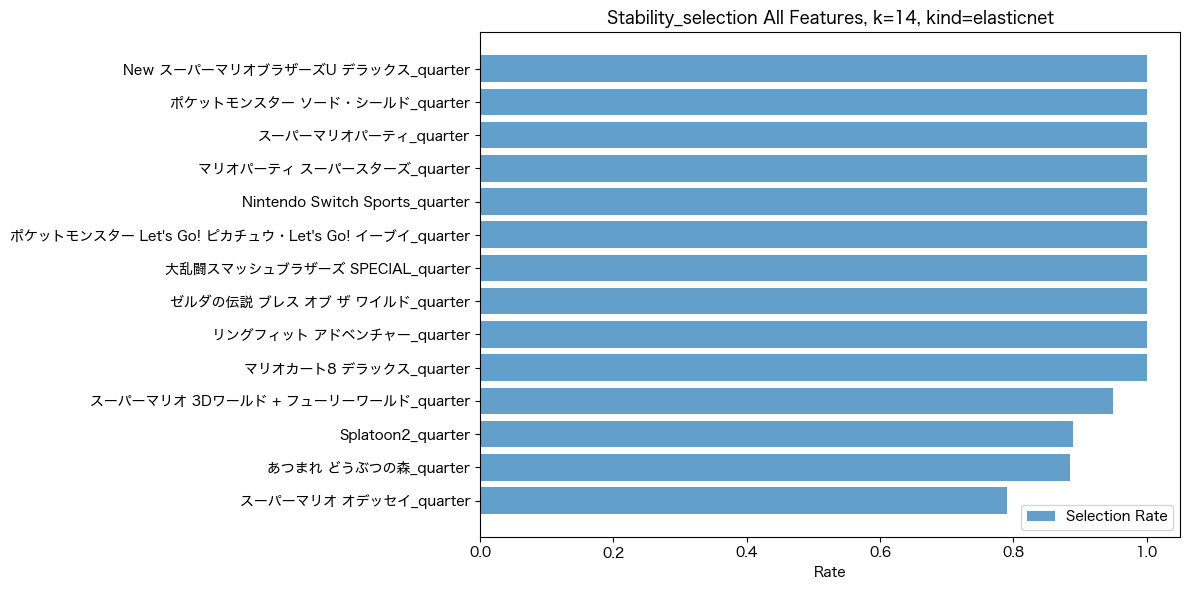

In [107]:
# 可視化
min_sel_rate=0.50,
kind, all_titles, ranked, top_view = summarize_stability(
    stab, # 
    k=15,
    min_sel_rate=min_sel_rate,
    # min_sign_stability=0.60
)
# print(all_titles)   # 閾値を満たすタイトル
# print(top_view)     # 上位k件のプレビュー

res = {}
res[f'res_{kind}'] = all_titles

plot_stability_summary(all_titles, title="All Features", kind=kind)
# plot_stability_summary(ranked, title="Ranked Features (selection_rate)", kind=kind)
# plot_stability_summary(top_view, title="Top-k Features (selection_rate)", kind=kind)

original_stab_sel_all_titles_elasticnet = all_titles
original_stab_sel_ranked_titles_elasticnet = ranked

In [108]:
# lassoで安定性選択

valid_titles = summary_df.loc[summary_df["データ数"] >= 8].index.tolist()
print(f"len(valid_titles):{len(valid_titles)}")
stab = stability_selection(
    df=selected_df[valid_titles+["hard_total_sales"]],
    y_col="hard_total_sales",
    X_cols=valid_titles,
    # kind="elasticnet",
    kind='lasso',
    n_repeats=200,
    sample_frac=0.7,            # 1回あたり連続ブロックの長さ（70%）
    n_splits=4,                 # 連続ブロック内のTimeSeriesSplit分割
    max_iter=500000,
    scoring="r2",
    random_state=0
)

# 全てのデータで安定性選択
# X_cols= [c for c in selected_cols if c != "hard_total_sales"]
# stab = stability_selection(
#     df=selected_df,
#     y_col="hard_total_sales",
#     X_cols=X_cols,
#     # kind="elasticnet",
#     kind='lasso',
#     n_repeats=200,
#     sample_frac=0.7,            # 1回あたり連続ブロックの長さ（70%）
#     n_splits=4,                 # 連続ブロック内のTimeSeriesSplit分割
#     max_iter=500000,
#     scoring="r2",
#     random_state=0
# )

len(valid_titles):14
[LASSO-TS] n_samples=23, n_features=14, nonzero=12/12  alpha=5.73615, l1_ratio=1.000
R2=0.9316, Adjusted R2=0.8494, Intercept=494.6087
ループ回数:1/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=3/3  alpha=38.5662, l1_ratio=1.000
R2=0.8885, Adjusted R2=0.8709, Intercept=513.9130
ループ回数:2/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=5/5  alpha=14.8735, l1_ratio=1.000
R2=0.9407, Adjusted R2=0.9233, Intercept=518.3478
ループ回数:3/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=3/3  alpha=38.5662, l1_ratio=1.000
R2=0.8940, Adjusted R2=0.8772, Intercept=515.5217
ループ回数:4/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=3/3  alpha=38.5662, l1_ratio=1.000
R2=0.8987, Adjusted R2=0.8827, Intercept=519.7391
ループ回数:5/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=9/9  alpha=9.23671, l1_ratio=1.000
R2=0.9380, Adjusted R2=0.8951, Intercept=486.8696
ループ回数:6/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=9/9  alpha=9.23671, l1_ratio=1.000
R2=0.9380, Adjuste

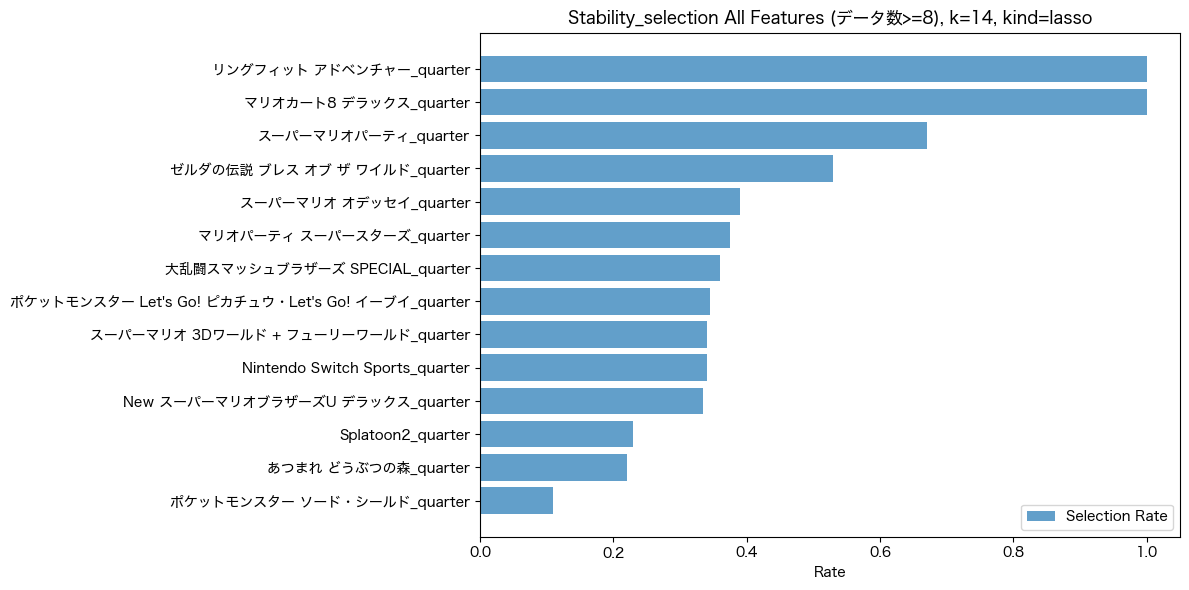

In [109]:
# 可視化
min_sel_rate=0.50,
kind, all_titles, ranked, top_view = summarize_stability(
    stab, # 
    k=15,
    min_sel_rate=min_sel_rate,
)
# print(all_titles)  # 閾値を満たす“安定して効く”タイトル
# print(top_view)　　 # 上位k件のプレビュー

res = {}
res[f'res_{kind}'] = all_titles

plot_stability_summary(all_titles, title="All Features (データ数>=8)", kind=kind)
# plot_stability_summary(ranked, title=f"Ranked Features (selection_rate >= {min_sel_rate})", kind=kind)
# plot_stability_summary(top_view, title="Top-k Features (selection_rate)", kind=kind)

original_stab_sel_all_titles_lasso = all_titles
original_stab_sel_ranked_titles_lasso = ranked

In [110]:
# elasticnetの安定性選択（季節調整はせず）ではほとんどのタイトルが80%以上の確率で残る。
# lassoの安定性選択（季節調整はせず）では、選択率の上位、中位、下位が見えた。このデータをベースにして、影響力のあるタイトルの傾向を考えていく。

# elasticnet、lassoの安定性選択の50％以上で残ったタイトルについて、ハード販売量との関係性を可視化

# stability_dfとして、以降の分析では次の２つのdfを使う。（どちらも、データ数>=8でフィルタしたdfを対象にした分析の戻り値）
display(original_stab_sel_all_titles_elasticnet)
display(original_stab_sel_all_titles_lasso)

,feature,selection_rate,sign_positive_share,sign_negative_share,sign_stability,hit_count,repeats
0,マリオカート8 デラックス_quarter,1.000,1.000000,0.000000,1.000000,200,200
1,リングフィット アドベンチャー_quarter,1.000,1.000000,0.000000,1.000000,200,200
2,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,1.000,1.000000,0.000000,1.000000,200,200
3,大乱闘スマッシュブラザーズ SPECIAL_quarter,1.000,1.000000,0.000000,1.000000,200,200
4,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter,1.000,1.000000,0.000000,1.000000,200,200
5,Nintendo Switch Sports_quarter,1.000,1.000000,0.000000,1.000000,200,200
6,マリオパーティ スーパースターズ_quarter,1.000,1.000000,0.000000,1.000000,200,200
7,スーパーマリオパーティ_quarter,1.000,0.880000,0.120000,0.880000,200,200
8,ポケットモンスター ソード・シールド_quarter,1.000,0.220000,0.780000,0.780000,200,200
9,New スーパーマリオブラザーズU デラックス_quarter,1.000,0.395000,0.605000,0.605000,200,200


,feature,selection_rate,sign_positive_share,sign_negative_share,sign_stability,hit_count,repeats
0,マリオカート8 デラックス_quarter,1.000,1.000000,0.000000,1.000000,200,200
1,リングフィット アドベンチャー_quarter,1.000,1.000000,0.000000,1.000000,200,200
2,スーパーマリオパーティ_quarter,0.670,1.000000,0.000000,1.000000,134,200
3,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,0.530,1.000000,0.000000,1.000000,106,200
4,スーパーマリオ オデッセイ_quarter,0.390,0.435897,0.564103,0.564103,78,200
5,マリオパーティ スーパースターズ_quarter,0.375,1.000000,0.000000,1.000000,75,200
6,大乱闘スマッシュブラザーズ SPECIAL_quarter,0.360,1.000000,0.000000,1.000000,72,200
7,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter,0.345,1.000000,0.000000,1.000000,69,200
8,Nintendo Switch Sports_quarter,0.340,1.000000,0.000000,1.000000,68,200
9,スーパーマリオ 3Dワールド + フューリーワールド_quarter,0.340,0.000000,1.000000,1.000000,68,200


In [ ]:
def select_lasso_titles(stability_df, min_prob=0.5, exclude_q=("Q_2","Q_3","Q_4"), k=None):
    """
    安定性選択の結果から、Lassoで選択確率>=min_probのタイトルを抽出。
    k:上位k件のパラメータ
    """
    df = stability_df.copy()
    # if "selection_rate" not in df.columns or "feature" not in df.columns:
    #     raise ValueError("stability_dfには feature と selection_rate 列が必要です。")
    mask = (~df["feature"].isin(exclude_q)) & (df["selection_rate"] >= min_prob)
    out = df.loc[mask].sort_values("selection_rate", ascending=False)
    if k is not None:
        out = out.head(k)
    return out["feature"].tolist()

def plot_titles_vs_hardware(
    df,
    stability_df=None,
    pickup_titles=[], #リスト
    y_col="hard_total_sales",
    min_prob=0.5,
    k=None,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,
    title="安定性選択タイトル × ハード販売量",
    left_ylabel = "タイトル販売量",
    right_ylabel = "ハード販売量",
    # figsize=(12, 6)
):
    """
    Lasso安定性選択の選択確率>=min_probのタイトル(必要なら上位k)を可視化
    右軸: ハード, 左軸: タイトル
    横軸: df.index（全期間）
    return: 描画したタイトルの一覧
    """
    # フォント
    if font_name is not None:
        plt.rcParams["font.family"] = font_name
    # タイトル選択
    if stability_df is not None:
        sel_titles = select_lasso_titles(stability_df, min_prob=min_prob, exclude_q=exclude_q, k=k)
    else:
        if not pickup_titles:
            raise ValueError("タイトルを指定してください。")
        sel_titles = pickup_titles
    # 存在チェック
    missing = [c for c in sel_titles + [y_col] if c not in df.columns]
    if missing:
        raise ValueError(f"dfに存在しない列があります: {missing}")
    x = df.index
    fig, ax_left = plt.subplots(figsize=(12, 6))
    # 左軸: タイトル
    for col in sel_titles:
        ax_left.plot(x, df[col], marker="o", linewidth=1.8, label=col)
    ax_left.set_ylabel(left_ylabel)
    # 右軸: ハード
    ax_right = ax_left.twinx()
    ax_right.bar(x, df[y_col], alpha=0.35, width=0.8, label=y_col)
    ax_right.set_ylabel(right_ylabel)

    if left_ylabel == "タイトル販売量残差":
        # 左右の 0 の位置をそろえる
        left_min = np.min(df[sel_titles].min().values)
        left_max = np.max(df[sel_titles].max().values)
        left_amp = max(abs(left_min), abs(left_max))
        if left_amp == 0:  # 全て0の保険
            left_amp = 1.0
        ax_left.set_ylim(-left_amp*1.05, left_amp*1.05)

        right_min = float(np.min(df[y_col]))
        right_max = float(np.max(df[y_col]))
        right_amp = max(abs(right_min), abs(right_max))
        if right_amp == 0:
            right_amp = 1.0
        ax_right.set_ylim(-right_amp*1.05, right_amp*1.05)

    # 軸・凡例・レイアウト
    ax_left.set_title(f"{title}（Lasso選択確率>={min_prob})")
                    # + (f", 上位{k}件" if k is not None else "") + "）")
    # 2軸の凡例をまとめる
    h1, l1 = ax_left.get_legend_handles_labels()
    h2, l2 = ax_right.get_legend_handles_labels()
    ax_left.legend(h1 + h2, l1 + l2, loc="upper left", ncol=1, frameon=True)
    # 目盛り調整
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

    return sel_titles

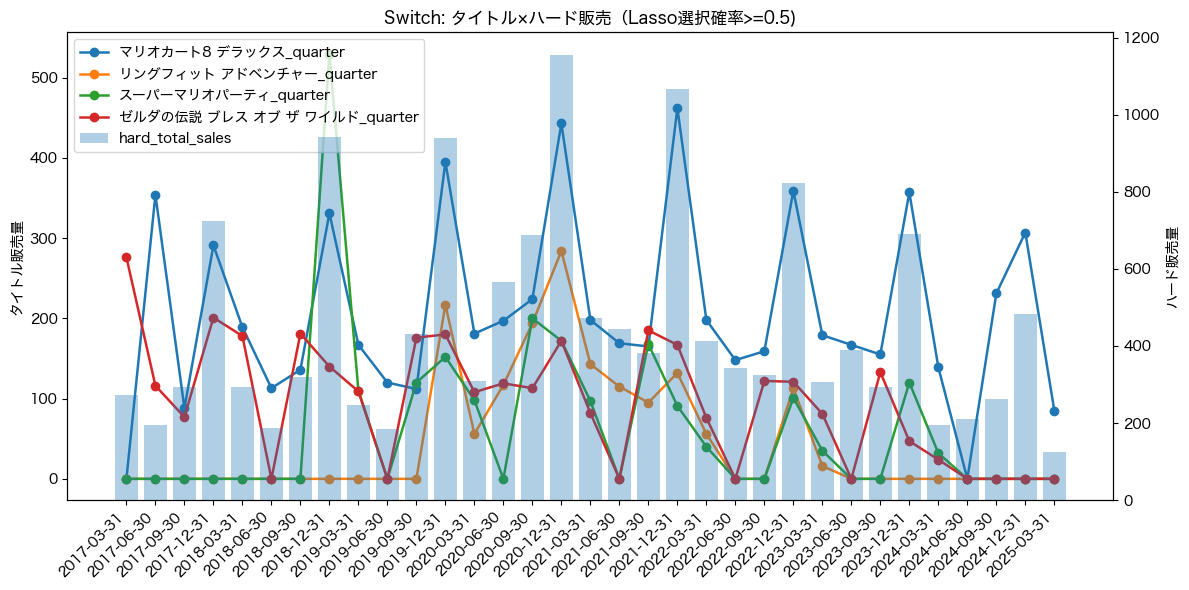

['マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'スーパーマリオパーティ_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter']

In [112]:
# all_titles: 安定性選択の上位結果タイトルDataFrame
# 選択確率>=0.5で描画。
plot_titles_vs_hardware(
    df=selected_df,
    stability_df=all_titles,
    y_col="hard_total_sales",
    min_prob=0.5,
    k=10,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,
    title="Switch: タイトル×ハード販売"
)

In [113]:
# 選択確率0.5以上、上位5本で描画。
# plot_titles_vs_hardware(
#     df=selected_df,
#     stability_df=all_titles,
#     y_col="hard_total_sales",
#     min_prob=0.5,
#     k=5,
#     exclude_q=("Q_2","Q_3","Q_4"),
#     font_name=None,
#     title="Switch: タイトル×ハード販売"
# )

In [114]:
# 第一四半期は、販売量100万本に到達せず、決算資料にタイトルが出ないため０になっているが、各期０に落ち込んでいるわけで歯ないことに注意する。
# "マリオカート8デラックス"の影響がローンチ日から長期にわたって継続、"リングフィットアドベンチャー"もハードの販売量と同じ動きをしている。
# ゼルダもロングテールなタイトルだが、ハード販売量の動きと連動していない。Sマリオパーティは、初期のスパイクは大きく販売期間も長く続いているが、初期スパイク後は季節イベントの影響が大きように見える。
# 季節性が排除されていないため、季節調整後の確認が必要。

In [115]:
# ここから、残差（季節性排除）で安定性選択　(データ数>=8でフィルタ)
valid_titles = summary_df.loc[summary_df["データ数"] >= 8].index.tolist()
valid_titles_with_resid =[t + "_resid" for t in valid_titles]
valid_titles_with_resid

# elasticnetと、lassoで安定性選択
# 季節性を取り除いた残差データは、seasonal_corr_filter_from_selected の戻り値 residuals_df を使う
# print(residuals_df.columns)
filtered_residuals_titles_by_count = residuals_df.columns.intersection(valid_titles_with_resid).to_list() + ["hard_total_sales_resid"]
filtered_residuals_titles_by_count # 残差化データからデータ数でフィルタしたタイトル
X_cols_resid = [c for c in filtered_residuals_titles_by_count if c != "hard_total_sales_resid"]
filtered_residuals_df_by_count = residuals_df[filtered_residuals_titles_by_count] # df
filtered_residuals_df_by_count.head()

,あつまれ どうぶつの森_quarter_resid,マリオカート8 デラックス_quarter_resid,リングフィット アドベンチャー_quarter_resid,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter_resid,大乱闘スマッシュブラザーズ SPECIAL_quarter_resid,スーパーマリオパーティ_quarter_resid,New スーパーマリオブラザーズU デラックス_quarter_resid,ポケットモンスター ソード・シールド_quarter_resid,スーパーマリオ オデッセイ_quarter_resid,Splatoon2_quarter_resid,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter_resid,Nintendo Switch Sports_quarter_resid,マリオパーティ スーパースターズ_quarter_resid,スーパーマリオ 3Dワールド + フューリーワールド_quarter_resid,hard_total_sales_resid
2017-03-31,-175.777778,-148.444444,-30.111111,172.222222,-69.222222,-4.577778e+01,-68.555556,-2.711111e+01,-5.677778e+01,-3.644444e+01,-1.466667e+01,-23.888889,-4.355556e+01,-78.222222,-18.777778
2017-06-30,-148.625000,195.500000,-29.000000,86.625000,-14.375000,4.947585e-14,0.000000,-2.968551e-14,4.947585e-14,-3.463309e-14,9.895169e-15,-60.500000,9.895169e-15,-13.625000,-119.375000
2017-09-30,-104.875000,-70.750000,-36.125000,-46.375000,-94.625000,-6.100000e+01,-66.375000,-3.987500e+01,-7.075000e+01,2.836250e+02,-4.233350e-14,-46.750000,-3.075000e+01,-24.625000,-81.500000
2017-12-31,-146.625000,-77.125000,-93.250000,72.500000,-266.250000,-1.457500e+02,-74.500000,-2.331250e+02,6.755000e+02,8.200000e+01,-1.651250e+02,-69.250000,-9.512500e+01,-42.250000,-129.750000
2018-03-31,-175.777778,40.555556,-30.111111,74.222222,-69.222222,-4.577778e+01,-68.555556,-2.711111e+01,7.722222e+01,7.455556e+01,-1.466667e+01,-23.888889,-4.355556e+01,-78.222222,0.222222


[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=12/12  alpha=9.23671, l1_ratio=0.800
R2=0.7268, Adjusted R2=0.3989, Intercept=28.5374
ループ回数:1/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=14/14  alpha=1.37382, l1_ratio=0.200
R2=0.7204, Adjusted R2=0.2311, Intercept=51.3949
ループ回数:2/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=14/14  alpha=5.73615, l1_ratio=0.200
R2=0.4252, Adjusted R2=-0.5806, Intercept=52.2766
ループ回数:3/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=12/12  alpha=14.8735, l1_ratio=0.800
R2=0.4617, Adjusted R2=-0.1843, Intercept=50.4330
ループ回数:4/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=13/13  alpha=9.23671, l1_ratio=0.800
R2=0.5586, Adjusted R2=-0.0790, Intercept=57.2210
ループ回数:5/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=11/11  alpha=5.73615, l1_ratio=0.800
R2=0.5911, Adjusted R2=0.1821, Intercept=45.1449
ループ回数:6/200回
[ELASTICNET-TS] n_samples=23, n_features=14, nonzero=11/11  alpha=5.73615, l1_ratio=0

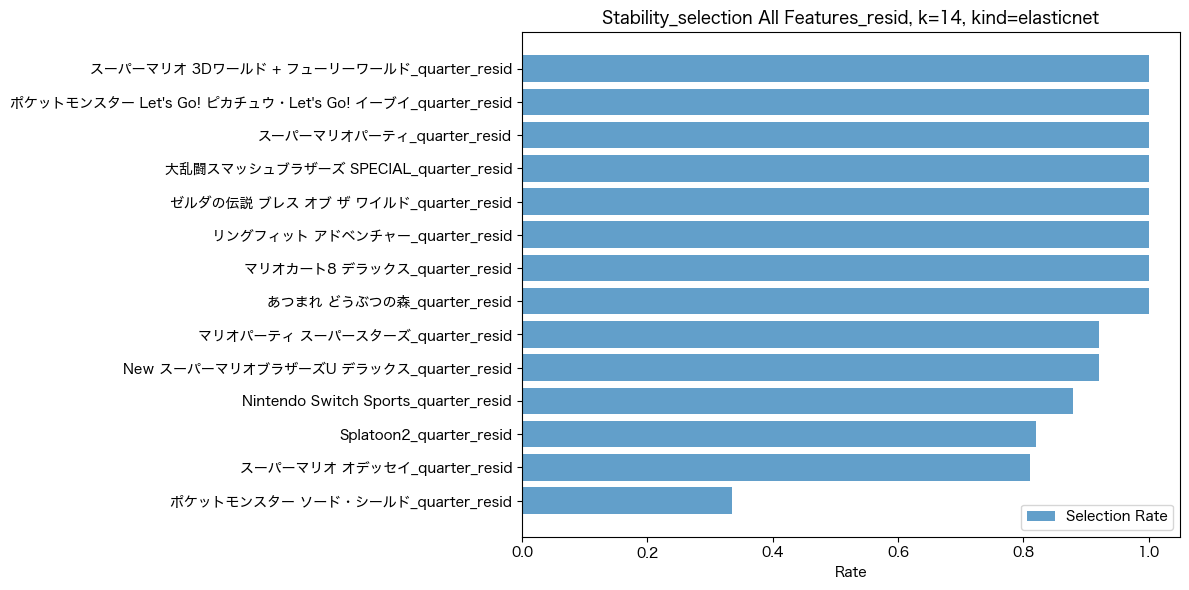

In [116]:
# 残差化したデータ（データ数>8）でのelasticnetの安定性選択
min_sel_rate = 0.5
stab = stability_selection(
    df=filtered_residuals_df_by_count,
    y_col="hard_total_sales_resid",
    X_cols=X_cols_resid,
    kind="elasticnet",
    # kind='lasso',
    n_repeats=200,
    sample_frac=0.7,            # 1回あたり連続ブロックの長さ（全体の70%）
    n_splits=4,                 # 連続ブロック内のTimeSeriesSplit分割
    max_iter=500000,
    scoring="r2",
    random_state=0
)

kind, all_titles, ranked, top_view = summarize_stability(
    stab,
    k=15,
    min_sel_rate=min_sel_rate,
    # min_sign_stability=0.60
)
print(all_titles)   # 実用閾値を満たすタイトル
# print(top_view)   # 上位k件のプレビュー

res = {}
res[f'res_{kind}'] = all_titles

resid_stab_sel_all_titles_elasticnet = all_titles
resid_stab_sel_ranked_titles_elasticnet = ranked

# 残差化したデータでのelasticnetの安定性選択の結果を可視化
plot_stability_summary(resid_stab_sel_all_titles_elasticnet, title=f"All Features_resid", kind=kind)

[LASSO-TS] n_samples=23, n_features=14, nonzero=4/4  alpha=38.5662, l1_ratio=1.000
R2=0.7223, Adjusted R2=0.6605, Intercept=28.5374
ループ回数:1/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=9/9  alpha=5.73615, l1_ratio=1.000
R2=0.8591, Adjusted R2=0.7616, Intercept=51.3949
ループ回数:2/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=4/4  alpha=23.9503, l1_ratio=1.000
R2=0.7072, Adjusted R2=0.6421, Intercept=52.2766
ループ回数:3/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=9/9  alpha=2.21222, l1_ratio=1.000
R2=0.8990, Adjusted R2=0.8291, Intercept=50.4330
ループ回数:4/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=6/6  alpha=9.23671, l1_ratio=1.000
R2=0.7874, Adjusted R2=0.7077, Intercept=57.2210
ループ回数:5/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=1/1  alpha=38.5662, l1_ratio=1.000
R2=0.5536, Adjusted R2=0.5324, Intercept=45.1449
ループ回数:6/200回
[LASSO-TS] n_samples=23, n_features=14, nonzero=1/1  alpha=38.5662, l1_ratio=1.000
R2=0.5536, Adjusted R2=0.5324, Intercept=45.144

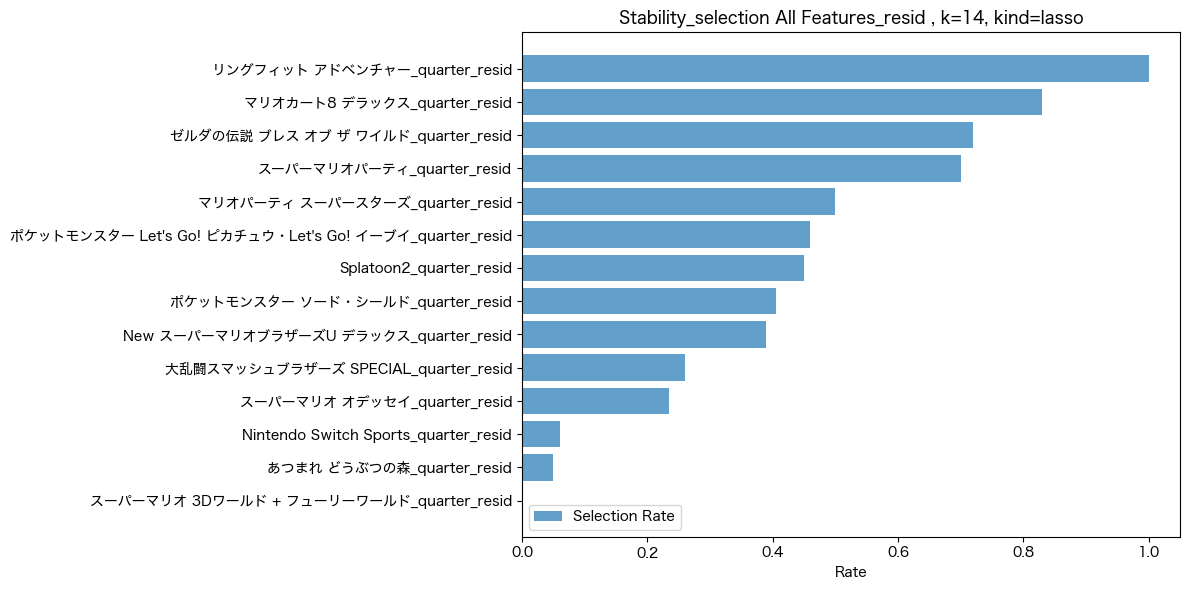

In [117]:
# 残差化したデータ（データ数>8）でのlassoの安定性選択
min_sel_rate = 0.5
stab = stability_selection(
    df=filtered_residuals_df_by_count,
    y_col="hard_total_sales_resid",
    X_cols=X_cols_resid,
    # kind="elasticnet",
    kind='lasso',
    n_repeats=200,
    sample_frac=0.7,            # 1回あたり連続ブロックの長さ（全体の70%）
    n_splits=4,                 # 連続ブロック内のTimeSeriesSplit分割
    max_iter=500000,
    scoring="r2",
    random_state=0
)

kind, all_titles, ranked, top_view = summarize_stability(
    stab,
    k=15,
    min_sel_rate=min_sel_rate,
    # min_sign_stability=0.60
)
print(all_titles)   # 実用閾値を満たす“安定して効く”タイトル
# print(top_view)   # 上位k件のプレビュー

res = {}
res[f'res_{kind}'] = all_titles

resid_stab_sel_all_titles_lasso = all_titles
resid_stab_sel_ranked_titles_lasso = ranked

plot_stability_summary(resid_stab_sel_all_titles_lasso, title="All Features_resid ", kind=kind)

In [118]:
# 残差化後 選択率>0.5
resid_stab_sel_all_titles_lasso[resid_stab_sel_all_titles_lasso["selection_rate"] > 0.5]["feature"].to_list()

['リングフィット アドベンチャー_quarter_resid',
 'マリオカート8 デラックス_quarter_resid',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter_resid',
 'スーパーマリオパーティ_quarter_resid']

In [119]:
# 残差化前 選択率>0.5
original_stab_sel_ranked_titles_lasso["feature"].to_list()

['マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'スーパーマリオパーティ_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter']

In [120]:
# 販売データ（季節調整前）と、残差データ（季節調整後）の安定化選択で選択率0.5のタイトルが同じ。
# データ数が一定以上のタイトルでは、一定程度の分析精度を期待しても良さそう。

In [121]:
# 可視化のために、各タイトル、ローンチ日以前のデータをnanに戻す
def zero_to_nan_prelaunch(original_df, resid_df):
    """
    各タイトルについて、最初に販売データが現れる時点より前（発売前）を NaN に戻す。
    対象: *_quarter → *_quarter_resid
    """
    fixed_resid_df = resid_df.copy()
    for col in original_df.columns:
        if not col.endswith("_quarter"):
            continue
        resid_col = col + "_resid"
        if resid_col in fixed_resid_df.columns:
            first_valid_idx = original_df[col].first_valid_index()
            if first_valid_idx is not None:
                mask = original_df.index < first_valid_idx
                fixed_resid_df.loc[mask, resid_col] = np.nan
    return fixed_resid_df

zero_to_nan_prelaunch(df, residuals_df).head(30)

,hard_total_sales_resid,あつまれ どうぶつの森_quarter_resid,マリオカート8 デラックス_quarter_resid,スーパーマリオ 3Dコレクション_quarter_resid,リングフィット アドベンチャー_quarter_resid,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter_resid,大乱闘スマッシュブラザーズ SPECIAL_quarter_resid,スーパーマリオパーティ_quarter_resid,New スーパーマリオブラザーズU デラックス_quarter_resid,ペーパーマリオ オリガミキング_quarter_resid,ポケットモンスター ソード・シールド_quarter_resid,ゼルダ無双 厄災の黙示録_quarter_resid,スーパーマリオ オデッセイ_quarter_resid,ルイージマンション3_quarter_resid,世界のアソビ大全51_quarter_resid,ピクミン3 デラックス_quarter_resid,Splatoon2_quarter_resid,Xenoblade Definitive Edition_quarter_resid,スーパーマリオメーカー2_quarter_resid,マリオカート ライブ ホームサーキット_quarter_resid,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter_resid,ポケットモンスター スカーレット・バイオレット_quarter_resid,Splatoon3_quarter_resid,Nintendo Switch Sports_quarter_resid,星のカービィ ディスカバリー_quarter_resid,マリオパーティ スーパースターズ_quarter_resid,マリオストライカーズ バトルリーグ_quarter_resid,Pokmon LEGENDS アルセウス_quarter_resid,スーパーマリオ 3Dワールド + フューリーワールド_quarter_resid,ゼノブレイド3_quarter_resid,ファイアーエムブレム エンゲージ_quarter_resid,星のカービィ Wii デラックス_quarter_resid,メトロイドプライム リマスタード_quarter_resid,ベヨネッタ3_quarter_resid,ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter_resid,ゼルダの伝説 スカイウォードソード HD_quarter_resid,メトロイド ドレッド_quarter_resid,New ポケモンスナップ_quarter_resid,マリオゴルフ スーパーラッシュ_quarter_resid,ミートピア_quarter_resid,やわらかあたま塾 いっしょにあたまのストレッチ_quarter_resid,おすそわける メイド イン ワリオ_quarter_resid,ナビつき！ つくってわかる はじめてゲームプログラミング_quarter_resid,ARMS_quarter_resid,1-2-Switch_quarter_resid,ゼノブレイド2_quarter_resid,星のカービィ スターアライズ_quarter_resid,ポッ拳 ポッケン トーナメント DX_quarter_resid,ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter_resid,Pikmin 4_quarter_resid,ゼルダの伝説 夢をみる島_quarter_resid,ファイアーエムブレム 風花雪月_quarter_resid,ASTRAL CHAIN_quarter_resid,MARVEL ULTIMATE ALLIANCE 3: The Black Order_quarter_resid,ゼルダの伝説 知恵のかりもの_quarter_resid,ペーパーマリオRPG_quarter_resid,ルイージマンション2 HD_quarter_resid,スーパー マリオパーティ ジャンボリー_quarter_resid,Super Mario Bros. Wonder_quarter_resid,マリオ&ルイージRPG ブラザーシップ!_quarter_resid,マリオテニス エース_quarter_resid,ドンキーコング トロピカルフリーズ_quarter_resid,スーパーマリオRPG_quarter_resid,プリンセスピーチ Showtime!_quarter_resid,マリオvs.ドンキーコング_quarter_resid,ドンキーコング リターンズ HD_quarter_resid,進め! キノピオ隊長_quarter_resid,OCTOPATH TRAVELER_quarter_resid,ヨッシークラフトワールド_quarter_resid,Nintendo Labo Toy-Con 01: Variety Kit_quarter_resid,ルイージマンション３_quarter_resid,おすそわける メイド イン ワリオ_quarter_resid,ポケモン不思議のダンジョン 救助隊DX_quarter_resid
2017-03-31,-18.777778,NaN,NaN,NaN,NaN,172.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-30,-119.375000,NaN,195.500000,NaN,NaN,86.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-30,-81.500000,NaN,-70.750000,NaN,NaN,-46.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.836250e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.875000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31,-129.750000,NaN,-77.125000,NaN,NaN,72.500000,NaN,NaN,NaN,NaN,NaN,NaN,6.755000e+02,NaN,NaN,NaN,8.200000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.750000,NaN,9.275000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-31,0.222222,NaN,40.555556,NaN,NaN,74.222222,NaN,NaN,NaN,NaN,NaN,NaN,7.722222e+01,NaN,NaN,NaN,7.455556e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.333333,1.191111e+02,2.222222e+01,1.104444e+02,1.031111e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201

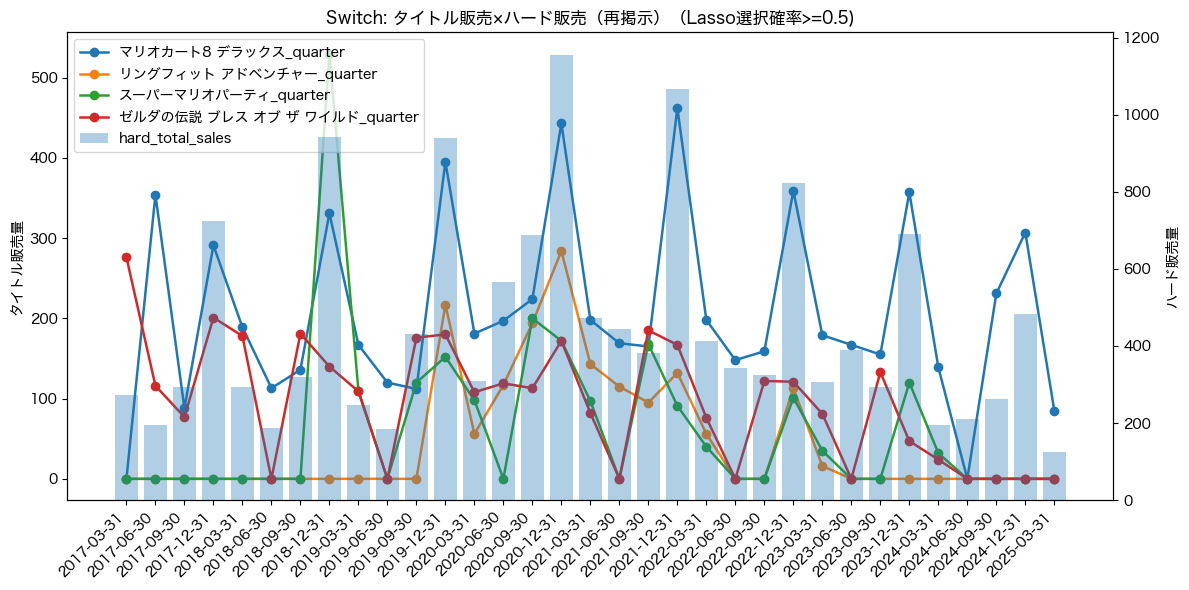

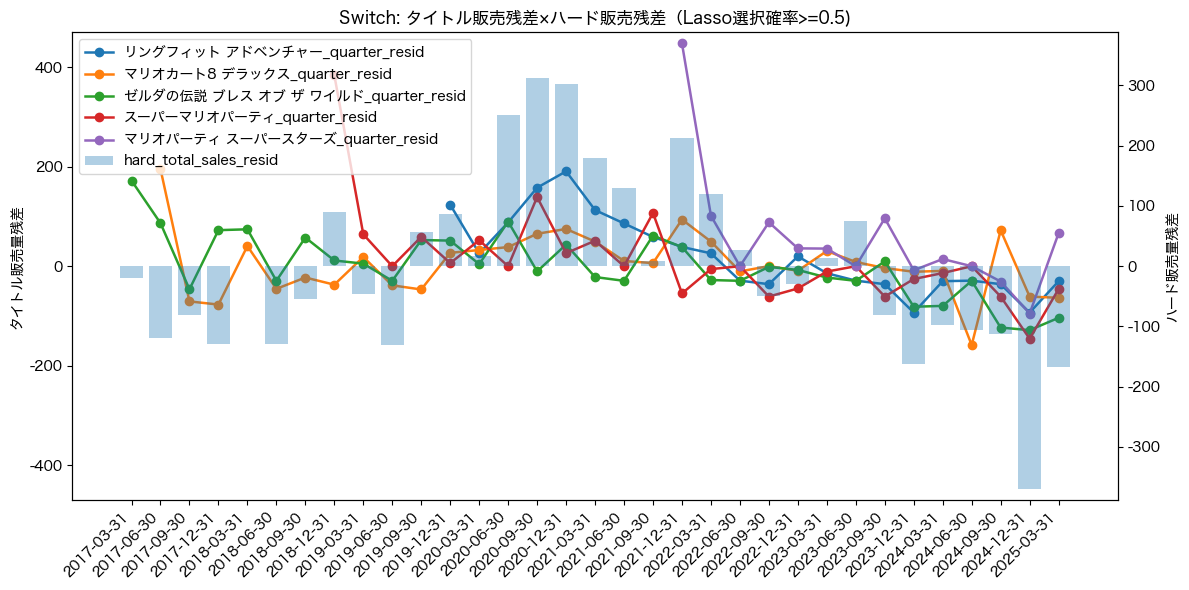

['リングフィット アドベンチャー_quarter_resid',
 'マリオカート8 デラックス_quarter_resid',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter_resid',
 'スーパーマリオパーティ_quarter_resid',
 'マリオパーティ スーパースターズ_quarter_resid']

In [122]:
# 安定性選択で影響が強く出たタイトル（データ数>=8, 選択率>=50%）の販売量を可視化
plot_titles_vs_hardware(
    df=selected_df,
    stability_df=original_stab_sel_all_titles_lasso, 
    y_col="hard_total_sales",
    min_prob=0.5,
    # k=5,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,           
    title="Switch: タイトル販売×ハード販売（再掲示）",
    left_ylabel = "タイトル販売量",
    right_ylabel = "ハード販売量",
)

plot_titles_vs_hardware(
    df=zero_to_nan_prelaunch(df, residuals_df), # ローンチ前のデータはnanにしてプロットは非表示にする
    # df = residuals_df,
    stability_df=resid_stab_sel_all_titles_lasso,
    y_col="hard_total_sales_resid",
    min_prob=0.5,
    # k=5,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,
    title="Switch: タイトル販売残差×ハード販売残差",
    left_ylabel = "タイトル販売量残差",
    right_ylabel = "ハード販売量残差",
)


In [123]:
# 残差化後データの2020第１四半期〜2021１四半期のプラスのスパイクは、新型コロナの影響で上振れしている可能性があるが、回帰モデル全体を大きく上振れさせるというほどでもない。
# ハードローンチ初期のマイナス残差は、発売後1年ほどの供給不足によるもの。当初販売見込みは年間1000万台（2018 年 3 ⽉期第２四半期決算説明会）。
# 一方で、供給体制が整い出したと考えらる2018後半からは、年末商戦販売量も伸び、2019年末のからのコロナのための需要増でピークを迎えている。
# 分析に有望な各タイトルは、どれもハードの販売状況に連動しているように見える。-> どのタイトルもハード売上を牽引した可能性がある
# リングフィット　新型コロナのパンデミックのタイミングを考えると、このタイトルがハード販売を大きく牽引。その後は減衰しているが、ハードへの影響はスラディングウィンドウで検証。
# マリオカート８　時期による振れはあるが、ハードの販売量に合わせて動いており、残差の動きの幅も一定。安定して、効いているタイトルと言える。
# ゼルダBOW　　　販売量はトップタイトルに比べ少ないが、残差はマリオカート同じく安定した動きをしており、ハードに対して一定の効果があったと言える。
# 　　　　　　　　各年度第１四半期は、販売１００万本に届かなかったため、決算資料のデータは欠損してる。そのため販売量０となり、谷が深く見えるが、実際は一定量の販売あったことを考慮する。
# スーパーマリオP　ローンチ2年ほどはハードと同様の動きをしているが、後半にかけて販売が減速している。


In [124]:
# 次に、lasso回帰elasticnet回帰を使った安定性選択でX％以上選択率になったタイトルだけを抽出して、スライディングウィンドウ回帰を試す
# ・販売データそのもの             original_stab_sel_all_titles_lasso  selected_df
# ・季節性を取り除いたデータ（残差） resid_stab_sel_all_titles_lasso     residuals_df

# 変数の影響度が時間の経過とともに安定しているのか、それとも変動しているのか。ただし、第1四半期はデータが欠損しているケースが多いので可視化結果を見る時には注意。

In [ ]:
def sliding_window_betas(
    df,
    stab_df,            # 安定性選択テーブル
    y_col,              # 目的変数（"hard_total_sales", 残差なら "hard_total_sales_resid"）
    data_type = "",     # "sales" or "resid"
    min_prob=0.5,       # 安定性選択の閾値
    k = 6,              # プロットする件数(上位 k タイトル)
    exclude_q=(),       # 除外列("Q_2","Q_3","Q_4")
    window=8,           # ウィンドウ長
    step=1,             # シフト幅
    kind="elasticnet",  # "lasso" | "ridge" | "elasticnet"
    alphas=None,        
    l1_ratios=None,     # ElasticNet のときのみ
    n_splits=3,         # TimeSeriesSplit の分割
    max_iter=100000,
    scoring="r2",
    random_state=0,
):
    """
    stab_df を使って上位の特徴量を抽出 -> スライディングウィンドウで係数（β）の時系列推移を算出
    returns: 行=ウィンドウ末尾のtimestamp, 列=係数（β）のDataFrame
    """
    df = df.fillna(0)
    # stab_dfから上位の特徴量を抽出
    filtered = stab_df.loc[stab_df["selection_rate"] >= min_prob, "feature"]
    feats = filtered[~filtered.isin(exclude_q)].tolist()

    if alphas is None:
        alphas = np.logspace(-4, 2, 30)

    if kind == "lasso":
        base = Lasso(max_iter=max_iter, random_state=random_state)
        param_grid = {"reg__alpha": alphas}
    elif kind == "ridge":
        base = Ridge(max_iter=max_iter, random_state=random_state)
        param_grid = {"reg__alpha": alphas}
    elif kind == "elasticnet":
        if l1_ratios is None:
            l1_ratios = [0.2, 0.5, 0.8]
        base = ElasticNet(max_iter=max_iter, random_state=random_state)
        param_grid = {"reg__alpha": alphas, "reg__l1_ratio": l1_ratios}
    else:
        raise ValueError("kind は 'lasso' / 'ridge' / 'elasticnet' のいずれか")

    steps = [("scaler", StandardScaler()), ("reg", base)]   
    pipe = Pipeline(steps)
    # ウィンドウを動かして係数推移を作る
    rows = []
    idx = []
    best_l1_ratios = []
    n = len(df)
    for end in range(window, n + 1, step):
        start = end - window
        sub = df.iloc[start:end, :]
        sub_xy = sub[[y_col] + feats].dropna()
        if len(sub_xy) < max(6, n_splits + 2):
            continue

        X = sub_xy[feats].to_numpy()
        y = sub_xy[y_col].to_numpy()
        splits = min(n_splits, max(2, len(sub_xy) // 4))
        tscv = TimeSeriesSplit(n_splits=splits)
        gscv = GridSearchCV(pipe, param_grid=param_grid, cv=tscv, scoring=scoring, refit=True)
        gscv.fit(X, y)

        reg = gscv.best_estimator_.named_steps["reg"]
        coef = reg.coef_
        rows.append(dict(zip(feats, coef)))
        idx.append(sub.index[-1])

        best_params = gscv.best_params_
        best_l1_ratio = best_params.get("reg__l1_ratio", None)
        best_l1_ratios.append(best_l1_ratio)

    betas = pd.DataFrame(rows, index=pd.Index(idx, name="window_end")).sort_index()
    plot_sliding_window_betas(betas, k=k, title=f"Sliding Window Betas {kind} / {data_type} / window={window} / step={step}")
    l1_ratio_series = pd.Series(best_l1_ratios, index=betas.index, name="l1_ratio")
    display(l1_ratio_series)
    return


def plot_sliding_window_betas(
    betas,
    k = None,
    title = "Sliding Window Betas",    
):
    """
    係数推移の可視化。k を指定すると直近ウィンドウの |coef| 上位のみ描画。
    """
    plt.figure(figsize=(12, 6))
    if k is not None and k < betas.shape[1]:
        cols = betas.iloc[-1].abs().sort_values(ascending=False).head(k).index.tolist()
        data = betas[cols]
    else:
        data = betas

    for c in data.columns:
        plt.plot(data.index, data[c], marker="o", linewidth=1.8, label=c)

    plt.axhline(0, color="gray", lw=1)
    plt.title(title)
    plt.ylabel("係数")
    plt.legend(loc="best", ncol=2, fontsize=9)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.813e+02, tolerance: 3.666e+01
  model = cd_fast.enet_coordinate_descent(


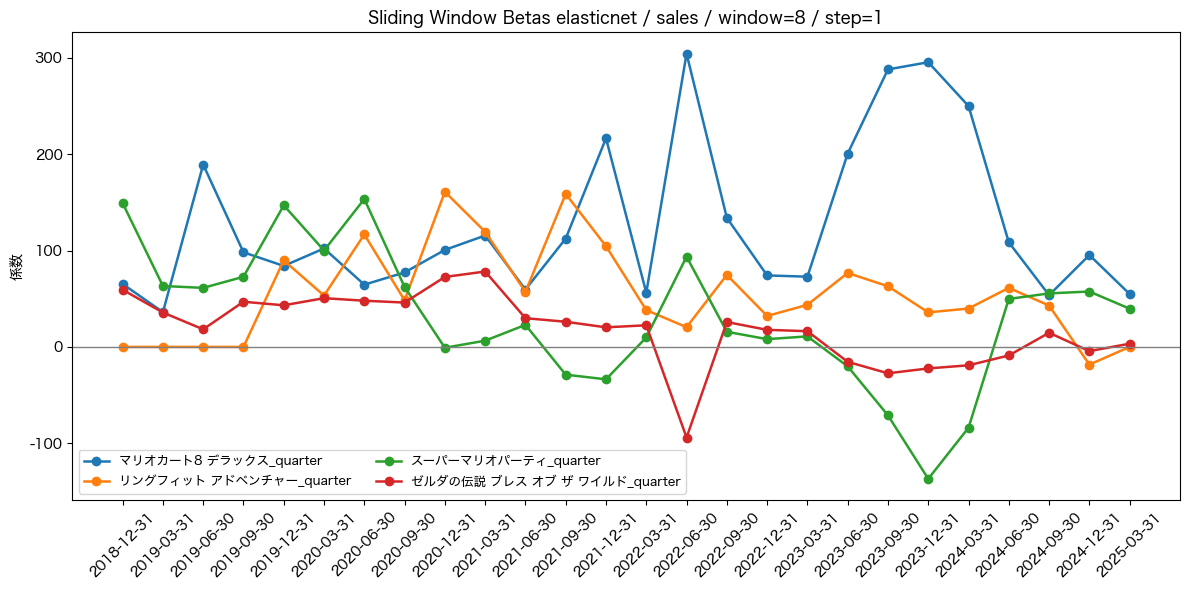

window_end
2018-12-31    0.8
2019-03-31    0.2
2019-06-30    0.8
2019-09-30    0.2
2019-12-31    0.2
2020-03-31    0.2
2020-06-30    0.8
2020-09-30    0.2
2020-12-31    0.8
2021-03-31    0.2
2021-06-30    0.8
2021-09-30    0.2
2021-12-31    0.8
2022-03-31    0.8
2022-06-30    0.8
2022-09-30    0.8
2022-12-31    0.8
2023-03-31    0.8
2023-06-30    0.2
2023-09-30    0.2
2023-12-31    0.8
2024-03-31    0.8
2024-06-30    0.8
2024-09-30    0.2
2024-12-31    0.2
2025-03-31    0.8
Name: l1_ratio, dtype: float64

/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.322e+01, tolerance: 3.666e+01
  model = cd_fast.enet_coordinate_descent(
/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.597e+01, tolerance: 3.666e+01
  model = cd_fast.enet_coordinate_descent(
/Users/fumi/Desktop/ProjectN/analysis_N/project_N_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

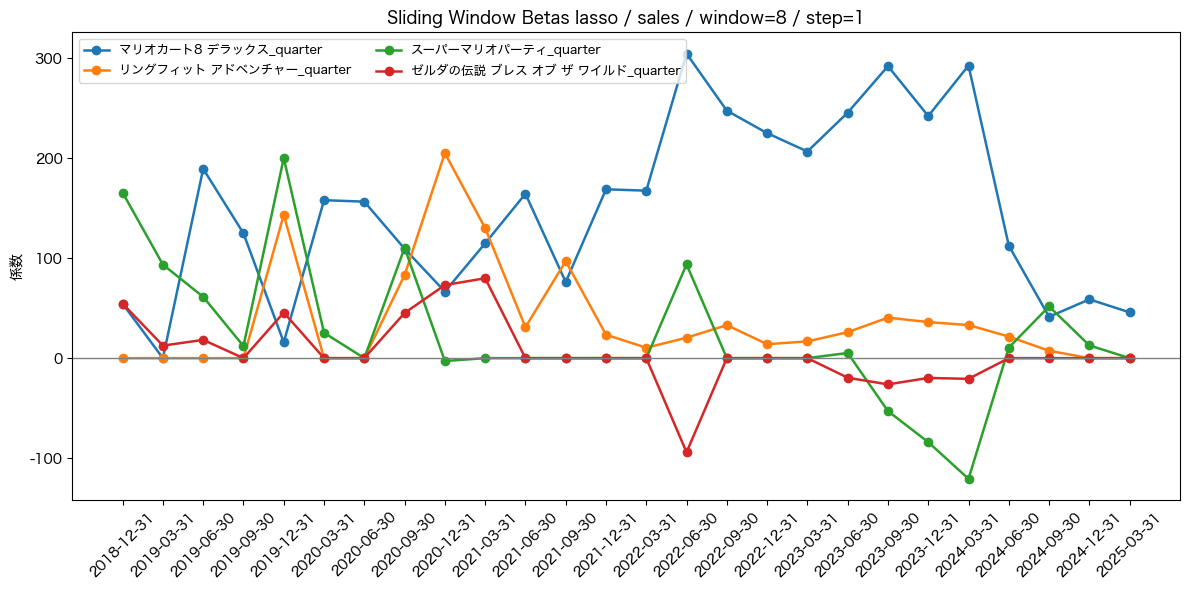

window_end
2018-12-31    None
2019-03-31    None
2019-06-30    None
2019-09-30    None
2019-12-31    None
2020-03-31    None
2020-06-30    None
2020-09-30    None
2020-12-31    None
2021-03-31    None
2021-06-30    None
2021-09-30    None
2021-12-31    None
2022-03-31    None
2022-06-30    None
2022-09-30    None
2022-12-31    None
2023-03-31    None
2023-06-30    None
2023-09-30    None
2023-12-31    None
2024-03-31    None
2024-06-30    None
2024-09-30    None
2024-12-31    None
2025-03-31    None
Name: l1_ratio, dtype: object

In [126]:
# elasticnet
min_prob = 0.5
exclude_q = ("Q_2", "Q_3", "Q_4")  # 四半期ダミーは除外
k = 10
sliding_window_betas(
    df=selected_df,
    stab_df=original_stab_sel_all_titles_lasso,
    y_col="hard_total_sales",
    data_type = "sales",
    min_prob=min_prob,
    k=k,
    exclude_q=exclude_q,
    window=8,              # ウィンドウ長（例: 8四半期）
    step=1,                # 1期ずつずらす
    kind="elasticnet",
    # kind="lasso",
    n_splits=3,            # 短い系列なので小さめに
    alphas=None,           # 既定の探索レンジでOK（標準化前提）
    l1_ratios=[0.2, 0.5, 0.8],  # ElasticNetの時だけ指定
)

# lasso
min_prob = 0.5
exclude_q = ("Q_2", "Q_3", "Q_4")  # 四半期ダミーは除外
k = 10
sliding_window_betas(
    df=selected_df,
    stab_df=original_stab_sel_all_titles_lasso,
    y_col="hard_total_sales",
    data_type = "sales",
    min_prob=min_prob,
    k=k,
    exclude_q=exclude_q,
    window=8,              # ウィンドウ長（例: 8四半期）
    step=1,                # 1期ずつずらす
    # kind="elasticnet",
    kind="lasso",
    n_splits=3,            # 短い系列なので小さめに
    alphas=None,           # 既定の探索レンジでOK（標準化前提）
    # l1_ratios=[0.2, 0.5, 0.8],  # ElasticNetの時だけ指定
)

In [127]:
# ここまでで一区切り
# 正則化の影響が強いLassoでは、ハード販売に対してどのタイトルが特に大きな影響を与えているかを見れそう。
# 一方、ElasticNetでは L1とL2の中間的な正則化のため、グラフも滑らかになっている

# マリオカートが主要タイトルとして長期間にわたってハード販売を牽引した。これらのタイトルの中では、圧倒的に効いているタイトルとして表現されている。
# 販売量のチャートでは、リングフィット、ゼルダは全期間を通して中位を保っていたが、回帰モデルの係数で評価すると、期間後半のハードへの寄与度は低く見える。
# リングフィットのハード販売への効き方で、2019年〜2021年が強いのは、新型コロナのパンデミックによる巣ごもり需要と一致している。
# マリオカート以外の３タイトルは、ローンチからしばらくは牽引タイトルとして機能したが、終盤の影響は限定的。一方、マリオカートの強さは変わらない。マリオカートは、ハード購入時の初期タイトルとなっている安納性が高い。

In [128]:
# ここで、その他のデータの分析
# 記述統計から、データの性質を読み解く　上位に残ったが安定化選択で0.5未満になったものや、販売後にスパイク的に売れるが、データ数が少ないもの。短期間でもハードへの影響が否定できなさそうなデータ。

In [129]:
# 記述統計の再掲
display(summary_df.sort_values("総販売量", ascending=False))

,データ数,平均,中央値,標準偏差,最小値,最大値,変動係数(CV),相関係数(hard_total_sales),p値(hard_total_sales),データ数(再掲),総販売量
マリオカート8 デラックス_quarter,31.0,219.968,181.0,105.269,85.0,462.0,0.479,0.831,0.0000,31.0,6819.0
あつまれ どうぶつの森_quarter,18.0,265.722,133.5,332.687,39.0,1177.0,1.252,0.203,0.4201,18.0,4783.0
大乱闘スマッシュブラザーズ SPECIAL_quarter,20.0,181.250,128.5,246.249,36.0,1208.0,1.359,0.387,0.0916,20.0,3625.0
ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,24.0,132.667,121.5,56.030,24.0,276.0,0.422,0.210,0.3248,24.0,3184.0
スーパーマリオ オデッセイ_quarter,20.0,146.450,110.5,186.181,24.0,907.0,1.271,0.280,0.2319,20.0,2929.0
ポケットモンスター スカーレット・バイオレット_quarter,7.0,382.714,113.0,741.204,41.0,2061.0,1.937,0.712,0.0726,7.0,2679.0
ポケットモンスター ソード・シールド_quarter,8.0,303.500,132.0,527.944,38.0,1606.0,1.740,0.335,0.4179,8.0,2428.0
ゼルダの伝説 ティアーズ オブ ザ キングダム_quarter,5.0,434.600,99.0,792.359,33.0,1851.0,1.823,0.127,0.8382,5.0,2173.0
スーパーマリオパーティ_quarter,15.0,137.733,110.0,119.373,32.0,530.0,0.867,0.464,0.0812,15.0,2066.0
New スーパーマリオブラザーズU デラックス_quarter,15.0,116.267,125.0,73.238,25.0,331.0,0.630,0.108,0.7022,15.0,1744.0


In [130]:
# 記述統計から、個別に見てみたいタイトルを抽出
# Splatoon2
# スマブラ
# あつ森
pickup_titles = ["あつまれ どうぶつの森_quarter", "大乱闘スマッシュブラザーズ SPECIAL_quarter", "Splatoon2_quarter"]
pickup_titles_resid = ["あつまれ どうぶつの森_quarter_resid", "大乱闘スマッシュブラザーズ SPECIAL_quarter_resid", "Splatoon2_quarter_resid"]

# ポケモンはデータ数が少ないにも関わらず、CV、最大値、総販売量が大きい。ローンチ直後のスパイクが極端に大きいタイトルで、一時のハード販売量には貢献するが、継続的に効くタイトルではない。
pokemon = [t for t in summary_df.index if "ポケ" in t or "Pok" in t] 
pokemon_resid = [t + "_resid" for t in pokemon]


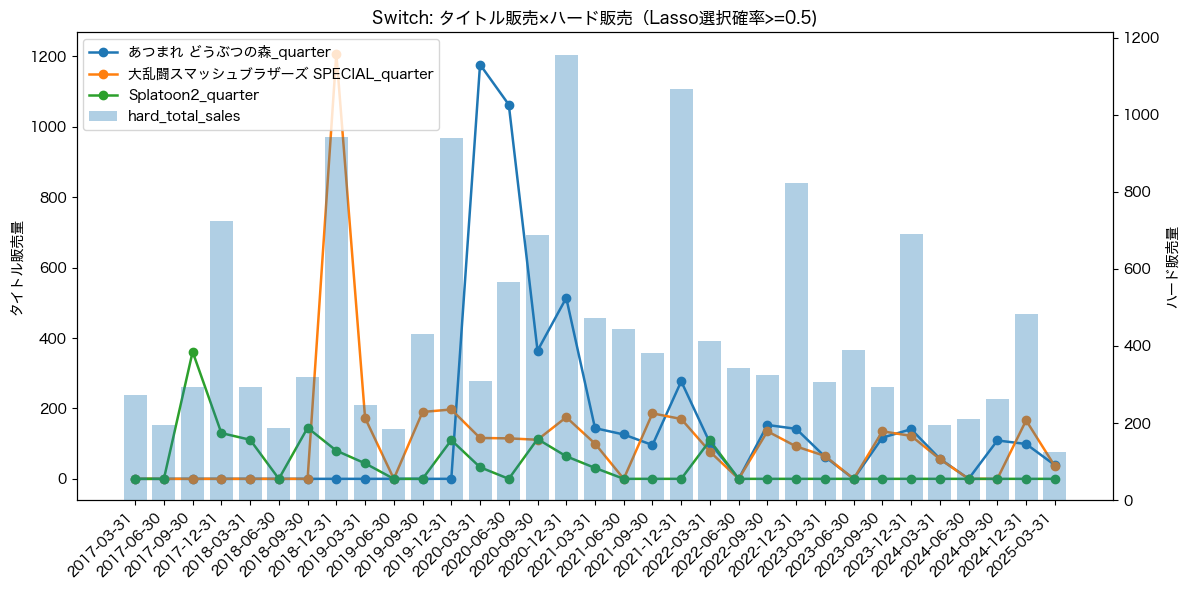

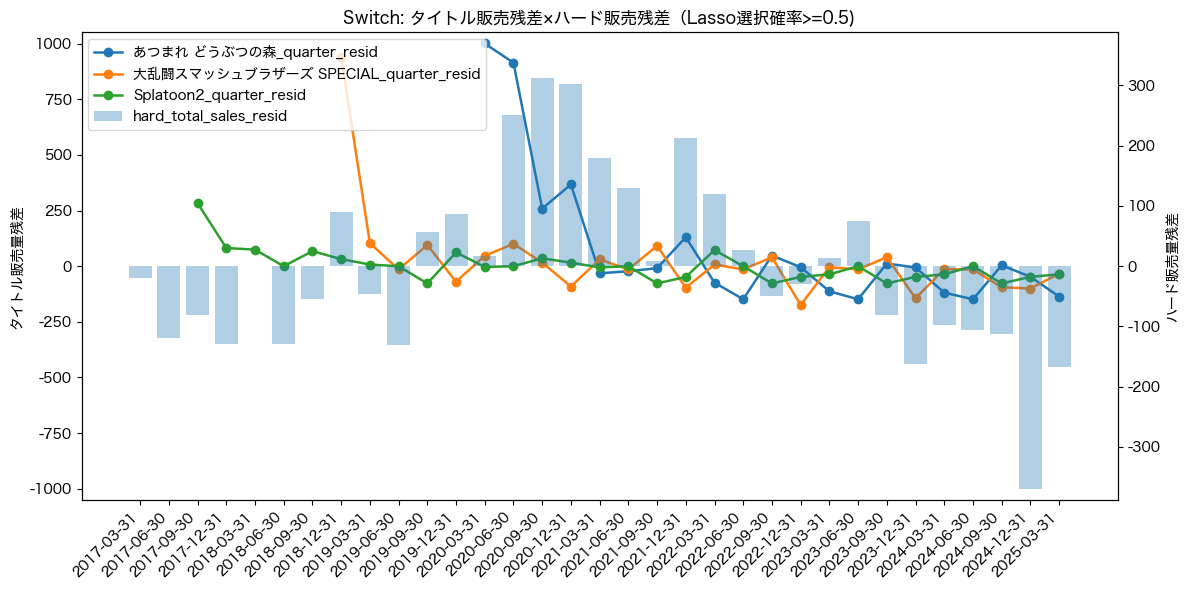

['あつまれ どうぶつの森_quarter_resid',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter_resid',
 'Splatoon2_quarter_resid']

In [131]:
plot_titles_vs_hardware(
    df=selected_df,
    # stability_df=original_stab_sel_all_titles_lasso, 
    pickup_titles=pickup_titles,
    y_col="hard_total_sales",
    min_prob=0.5,
    # k=5,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,           
    title="Switch: タイトル販売×ハード販売",
    left_ylabel = "タイトル販売量",
    right_ylabel = "ハード販売量",
)

plot_titles_vs_hardware(
    df=zero_to_nan_prelaunch(df, residuals_df), # ローンチ前のデータはnanにしてプロットは非表示にする
    # df = residuals_df,
    # stability_df=resid_stab_sel_all_titles_lasso,
    pickup_titles=pickup_titles_resid,
    y_col="hard_total_sales_resid",
    min_prob=0.5,
    # k=5,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,
    title="Switch: タイトル販売残差×ハード販売残差",
    left_ylabel = "タイトル販売量残差",
    right_ylabel = "ハード販売量残差",
)

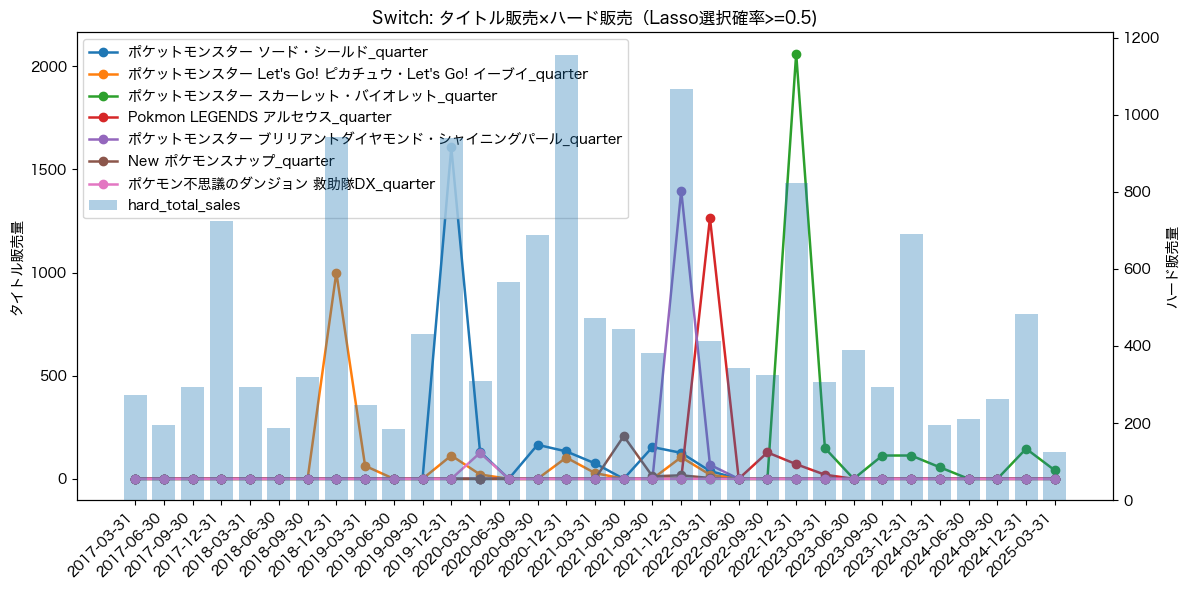

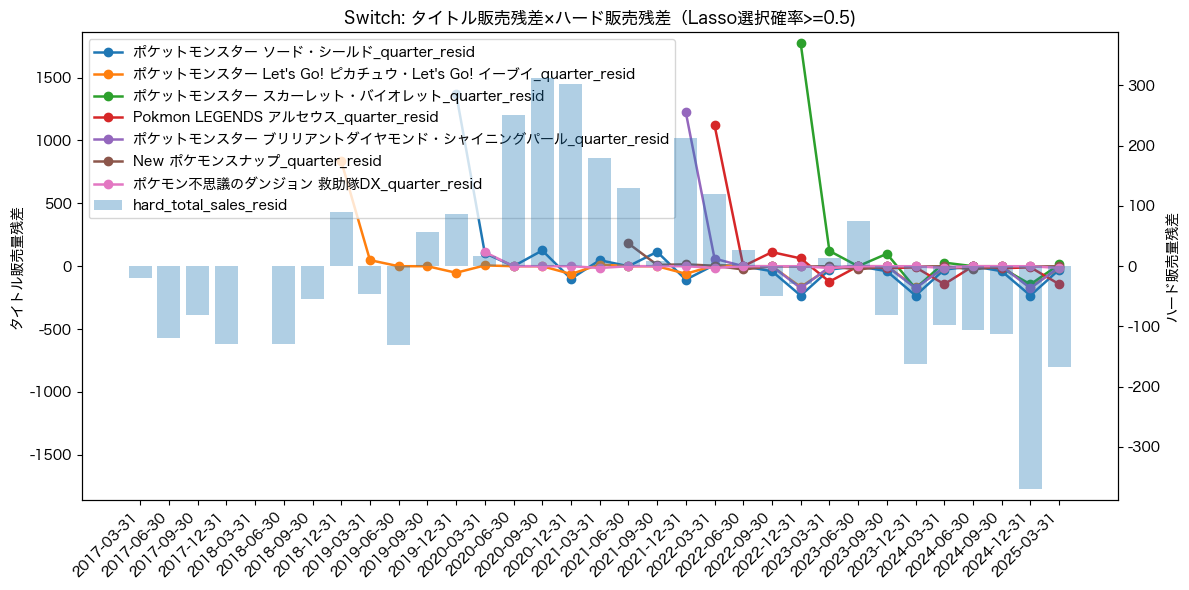

['ポケットモンスター ソード・シールド_quarter_resid',
 "ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter_resid",
 'ポケットモンスター スカーレット・バイオレット_quarter_resid',
 'Pokmon LEGENDS アルセウス_quarter_resid',
 'ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter_resid',
 'New ポケモンスナップ_quarter_resid',
 'ポケモン不思議のダンジョン 救助隊DX_quarter_resid']

In [132]:
plot_titles_vs_hardware(
    df=selected_df,
    # stability_df=original_stab_sel_all_titles_lasso, 
    pickup_titles=pokemon,
    y_col="hard_total_sales",
    min_prob=0.5,
    # k=5,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,           
    title="Switch: タイトル販売×ハード販売",
    left_ylabel = "タイトル販売量",
    right_ylabel = "ハード販売量",
)

plot_titles_vs_hardware(
    df=zero_to_nan_prelaunch(df, residuals_df), # ローンチ前のデータはnanにしてプロットは非表示にする
    # df = residuals_df,
    # stability_df=resid_stab_sel_all_titles_lasso,
    pickup_titles=pokemon_resid,
    y_col="hard_total_sales_resid",
    min_prob=0.5,
    # k=5,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,
    title="Switch: タイトル販売残差×ハード販売残差",
    left_ylabel = "タイトル販売量残差",
    right_ylabel = "ハード販売量残差",
)

In [133]:
selected_df[pokemon]

,ポケットモンスター ソード・シールド_quarter,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter,ポケットモンスター スカーレット・バイオレット_quarter,Pokmon LEGENDS アルセウス_quarter,ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter,New ポケモンスナップ_quarter,ポケモン不思議のダンジョン 救助隊DX_quarter
2017-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,0.0,1000.0,0.0,0.0,0.0,0.0,0.0
2019-03-31,0.0,63.0,0.0,0.0,0.0,0.0,0.0
2019-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
# あつ森、スマブラ、スプラはどれも売れ行きはどれも長期間続くが、あつ森、スマブラはローンチ直後にスパイク的な販売量を示していることから、発売初期はハード売上を牽引した可能性は高い。
# 残差分析では、あつ森の初期のピークが際立っている。ハード販売の残差も伸びており、かつ2020/6,9,12月期には、他に同様な伸びを示すタイトルはないので、このタイトルがハード販売を牽引した可能性がある。
# スプラの残差は低位で安定。ハード新規購入層の初期タイトルとして毎期の一定量の売上に貢献

# ポケモンはどれも初期スパイクが大きく1000万本以上売るが、その後の安定性ない。ハードの潜在的購入者の意欲がピークになりそうな年末などの季節性を考慮して、購入の決断を後押しするためのタイトルとして効く
# 競争相手のハードウェアがローンチされるタイミングに自社ハードを優先してもらうための、差別化要因のタイトルになる

# これらのタイトルの販売量のスライディング回帰

In [135]:
original_stab_sel_all_titles_lasso

,feature,selection_rate,sign_positive_share,sign_negative_share,sign_stability,hit_count,repeats
0,マリオカート8 デラックス_quarter,1.000,1.000000,0.000000,1.000000,200,200
1,リングフィット アドベンチャー_quarter,1.000,1.000000,0.000000,1.000000,200,200
2,スーパーマリオパーティ_quarter,0.670,1.000000,0.000000,1.000000,134,200
3,ゼルダの伝説 ブレス オブ ザ ワイルド_quarter,0.530,1.000000,0.000000,1.000000,106,200
4,スーパーマリオ オデッセイ_quarter,0.390,0.435897,0.564103,0.564103,78,200
5,マリオパーティ スーパースターズ_quarter,0.375,1.000000,0.000000,1.000000,75,200
6,大乱闘スマッシュブラザーズ SPECIAL_quarter,0.360,1.000000,0.000000,1.000000,72,200
7,ポケットモンスター Let's Go! ピカチュウ・Let's Go! イーブイ_quarter,0.345,1.000000,0.000000,1.000000,69,200
8,Nintendo Switch Sports_quarter,0.340,1.000000,0.000000,1.000000,68,200
9,スーパーマリオ 3Dワールド + フューリーワールド_quarter,0.340,0.000000,1.000000,1.000000,68,200


In [136]:
pickup_titles

['あつまれ どうぶつの森_quarter', '大乱闘スマッシュブラザーズ SPECIAL_quarter', 'Splatoon2_quarter']

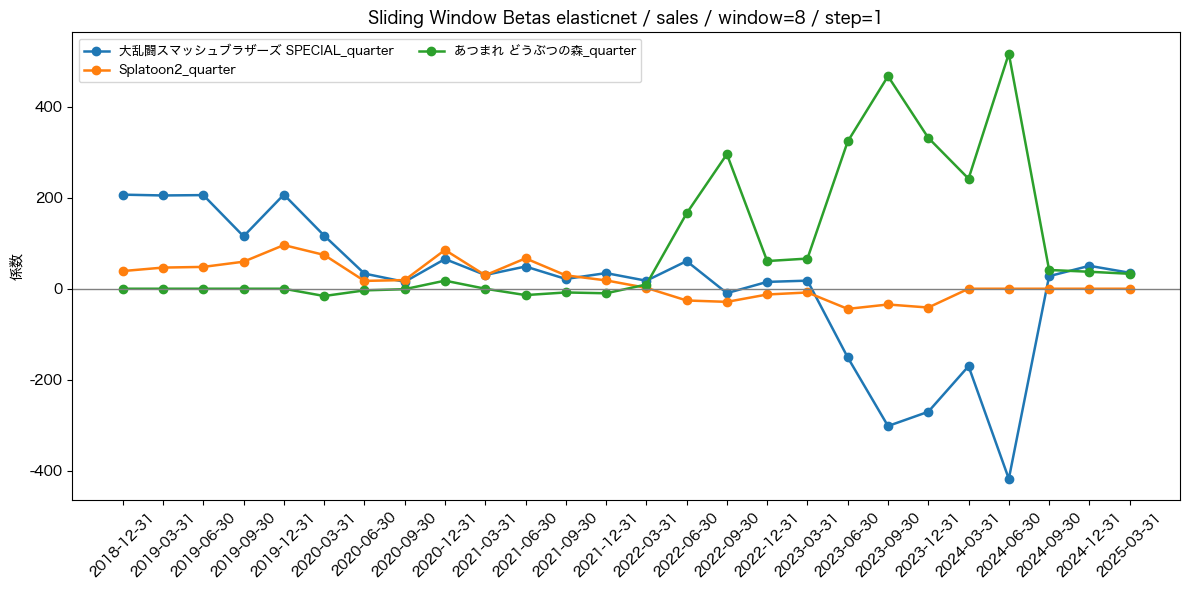

window_end
2018-12-31    0.8
2019-03-31    0.8
2019-06-30    0.8
2019-09-30    0.2
2019-12-31    0.8
2020-03-31    0.2
2020-06-30    0.2
2020-09-30    0.8
2020-12-31    0.2
2021-03-31    0.8
2021-06-30    0.8
2021-09-30    0.2
2021-12-31    0.5
2022-03-31    0.2
2022-06-30    0.8
2022-09-30    0.8
2022-12-31    0.8
2023-03-31    0.8
2023-06-30    0.8
2023-09-30    0.8
2023-12-31    0.8
2024-03-31    0.8
2024-06-30    0.8
2024-09-30    0.2
2024-12-31    0.8
2025-03-31    0.2
Name: l1_ratio, dtype: float64

In [137]:
# elasticnet
min_prob = 0.1
exclude_q = ("Q_2", "Q_3", "Q_4")  # 四半期ダミーは除外
k = 10
sliding_window_betas(
    df=selected_df,
    stab_df=original_stab_sel_all_titles_lasso.loc[original_stab_sel_all_titles_lasso["feature"].isin(pickup_titles)],
    y_col="hard_total_sales",
    data_type = "sales",
    min_prob=min_prob,
    k=k,
    exclude_q=exclude_q,
    window=8,              # ウィンドウ長（例: 8四半期）
    step=1,                # 1期ずつずらす
    kind="elasticnet",
    # kind="lasso",
    n_splits=3,            # 短い系列なので小さめに
    alphas=None,           # 既定の探索レンジでOK（標準化前提）
    l1_ratios=[0.2, 0.5, 0.8],  # ElasticNetの時だけ指定
)

# # lasso
# min_prob = 0.1
# exclude_q = ("Q_2", "Q_3", "Q_4")  # 四半期ダミーは除外
# k = 10
# sliding_window_betas(
#     df=selected_df,
#     stab_df=original_stab_sel_all_titles_lasso.loc[original_stab_sel_all_titles_lasso["feature"].isin(pickup_titles)],
#     y_col="hard_total_sales",
#     data_type = "sales",
#     min_prob=min_prob,
#     k=k,
#     exclude_q=exclude_q,
#     window=8,              # ウィンドウ長（例: 8四半期）
#     step=1,                # 1期ずつずらす
#     # kind="elasticnet",
#     kind="lasso",
#     n_splits=3,            # 短い系列なので小さめに
#     alphas=None,           # 既定の探索レンジでOK（標準化前提）
#     # l1_ratios=[0.2, 0.5, 0.8],  # ElasticNetの時だけ指定
# )

# # ridge
# min_prob = 0.1
# exclude_q = ("Q_2", "Q_3", "Q_4")  # 四半期ダミーは除外
# k = 10
# sliding_window_betas(
#     df=selected_df,
#     stab_df=original_stab_sel_all_titles_lasso.loc[original_stab_sel_all_titles_lasso["feature"].isin(pickup_titles)],
#     y_col="hard_total_sales",
#     data_type = "sales",
#     min_prob=min_prob,
#     k=k,
#     exclude_q=exclude_q,
#     window=8,              # ウィンドウ長（例: 8四半期）
#     step=1,                # 1期ずつずらす
#     # kind="elasticnet",
#     kind="ridge",
#     n_splits=3,            # 短い系列なので小さめに
#     alphas=None,           # 既定の探索レンジでOK（標準化前提）
#     # l1_ratios=[0.2, 0.5, 0.8],  # ElasticNetの時だけ指定
# )

In [138]:
# スマブラとあつ森の多重共線性の影響が強く出て、特に後半は評価が難しい
# 前半は、ローンチ前のデータも算入される。

In [139]:
# ここで、「あつ森、スマブラ、スプラ」３タイトルに、安定性性選択でlasso選択率>0.5のタイトルを重ねて分析してみる

In [140]:
original_stab_sel_ranked_titles_lasso["feature"].to_list()

['マリオカート8 デラックス_quarter',
 'リングフィット アドベンチャー_quarter',
 'スーパーマリオパーティ_quarter',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter']

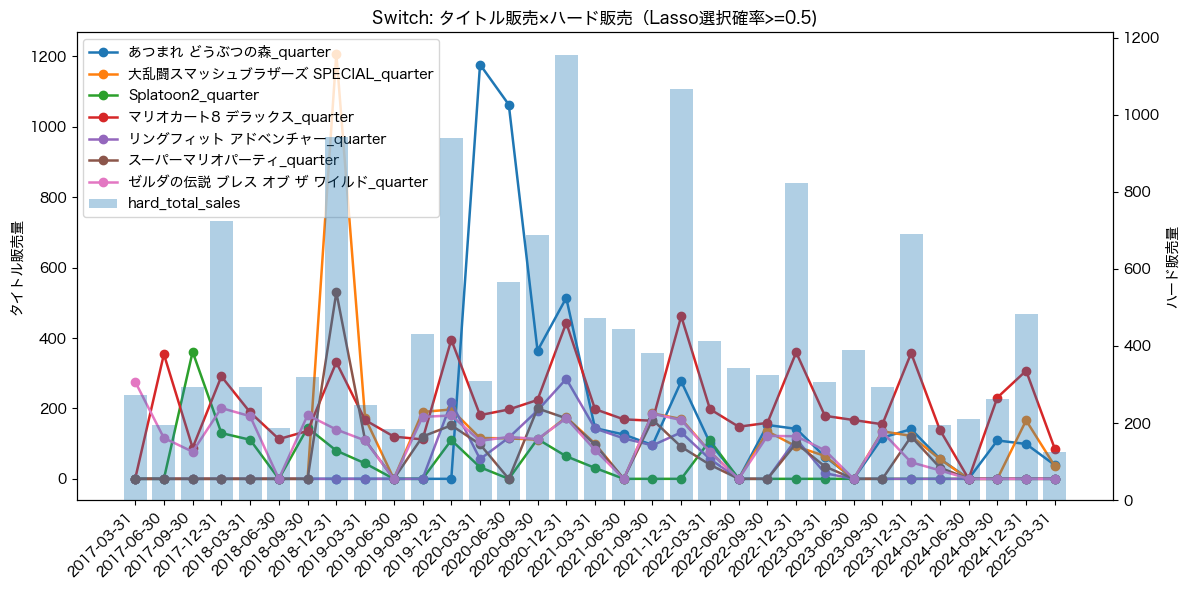

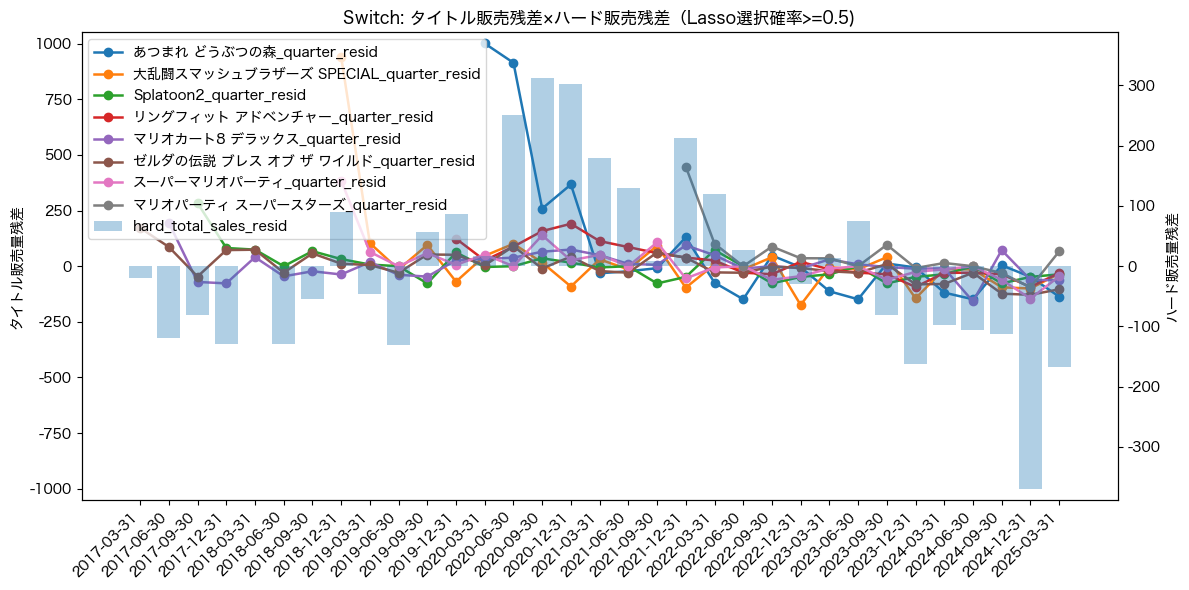

['あつまれ どうぶつの森_quarter_resid',
 '大乱闘スマッシュブラザーズ SPECIAL_quarter_resid',
 'Splatoon2_quarter_resid',
 'リングフィット アドベンチャー_quarter_resid',
 'マリオカート8 デラックス_quarter_resid',
 'ゼルダの伝説 ブレス オブ ザ ワイルド_quarter_resid',
 'スーパーマリオパーティ_quarter_resid',
 'マリオパーティ スーパースターズ_quarter_resid']

In [141]:
plot_titles_vs_hardware(
    df=selected_df,
    # stability_df=original_stab_sel_all_titles_lasso, 
    pickup_titles=pickup_titles + original_stab_sel_ranked_titles_lasso["feature"].to_list(),
    y_col="hard_total_sales",
    min_prob=0.5,
    # k=5,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,           
    title="Switch: タイトル販売×ハード販売",
    left_ylabel = "タイトル販売量",
    right_ylabel = "ハード販売量",
)

plot_titles_vs_hardware(
    df=zero_to_nan_prelaunch(df, residuals_df), # ローンチ前のデータはnanにしてプロットは非表示にする
    # df = residuals_df,
    # stability_df=resid_stab_sel_all_titles_lasso,
    pickup_titles=pickup_titles_resid + resid_stab_sel_ranked_titles_lasso["feature"].to_list(),
    y_col="hard_total_sales_resid",
    min_prob=0.5,
    # k=5,
    exclude_q=("Q_2","Q_3","Q_4"),
    font_name=None,
    title="Switch: タイトル販売残差×ハード販売残差",
    left_ylabel = "タイトル販売量残差",
    right_ylabel = "ハード販売量残差",
)


In [142]:
# あつ森、スマブラ　どちらも初期のスパイクが大きく、ハード販売量との同期具合を見るとスマブラはハード購入のトリガーとなった可能性があり、短期的とはいえ明確なハード売上げの牽引タイトルと言える。
# 一方で、あつ森は新型コロナのパンデミックの時期と重なり、約1年に渡ってハードの販売を支えたことが伺える。
# マリカは発売初期から通期でハードとセット購入される基盤タイトルとなっている。 変動係数:0.479, 相関係数:0.831, p値（相関係数）:0.0000, データ数:31.0, 総販売量:6819.0
# 残りの、スプラ、リングフィット、ゼルダ、Sマリオパーティは、後半にかけて売上げを落とすが、発売以降長期にわたり安定した販売を継続している。どれも残差が０付近で安定していることからも、季節性やイベントに左右されずにハード販売のベース部分を支えたと考えられる。

# スプラや安定性選択で残ったタイトルは、市場維持とベース需要の安定化を支える存在といえる。
# ハードの残差　2020〜21のプラス残差は、新型コロナ＋あつ森・リングフィットによる需要の超過
#             ハードのローンチ初期のマイナス残差は、データ不足による回帰モデルの不安定さと、供給不足による販売機械の喪失によるもの
#             2023以降のマイナス残差は、ハードのモデル末期の買い控え


# 次の分析
# 残差相関を見る


#### 以下、初手で試したコードの後半部分  
初手は データ数>4 で分析を始め、以降のコードを最後まで試して分析した。  
結果が安定しないので、データ数>8 で再度分析したものが、このセルより上の部分。

<!-- 以下、初手で試した終盤のコード
初手の前半は、ここまでのコードをデータ数>4のフィルタで分析してきた。
これ以降コードで分析をした結果、データ数>8でフィルタし直して再度分析した方が良さそうだとか考え、初手に戻る -->

In [ ]:
# 販売量でフィルタ -> 安定化選択
display(summary_df[(summary_df["総販売量"] >= 1000)].sort_values("データ数", ascending=False))
print(len(summary_df[(summary_df["総販売量"] >= 1000)]))

In [ ]:
total_sales_df = culc_total_sales(selected_df)
titles_filtered_by_sales = get_titles_filtered_by_sales(total_sales_df, min_sales=1000) # total_sales_dfは初手で作成済
filtered_titles_by_sales_df = selected_df[["Q_2", "Q_3", "Q_4"] + titles_filtered_by_sales + ["hard_total_sales"]]
len(filtered_titles_by_sales_df.columns)


In [ ]:
print("== 季節性調整後のタイトルでフィルタ ==")
seasonal_corr_df_sales_datas, filtered_cols_sales_datas, residuals_df_sales_datas = seasonal_corr_filter_from_selected(filtered_titles_by_sales_df, corr_thld=0.35)

# 季節調整後の相関でフィルタしたタイトルでcompare_allを実行
# display(compare_all(filtered_titles_by_count_df, y_col, filtered_cols_count_datas, max_iter=500000, nonzero_threshold=1e-12))
# print("== こここまで 季節調整後の相関でフィルタしてcompare_all ==")
# display(filtered_titles_by_count_df)

In [ ]:
residuals_df_sales_datas.columns
X_cols_resid = [c for c in residuals_df_sales_datas.columns if c != "hard_total_sales_resid"]

In [ ]:
# elasticnetで安定性選択
stab = stability_selection(
    df=residuals_df_sales_datas,
    y_col="hard_total_sales_resid",
    X_cols=X_cols_resid,
    kind="elasticnet",
    # kind='lasso',
    n_repeats=200,
    sample_frac=0.7,            # 1回あたり連続ブロックの長さ（70%）
    n_splits=4,                 # 連続ブロック内のTimeSeriesSplit分割
    max_iter=500000,
    scoring="r2",
    random_state=0
)

kind, all_titles, ranked, top_view = summarize_stability(
    stab,
    k=15,
    min_sel_rate=0.30,
    min_sign_stability=0.60
)
# print(all_titles)  # 閾値を満たす“安定して効く”タイトル
# print(top_view)　　 # 上位k件のプレビュー

res = {}
res[f'res_{kind}'] = all_titles

plot_stability_summary(all_titles, title="All Features (selection_rate)", kind=kind)
# plot_stability_summary(ranked, title="Ranked Features (selection_rate)", kind=kind)
# plot_stability_summary(top_view, title="Top-k Features (selection_rate)", kind=kind)

sales_datas_stab_sel_all_titles_lasso = all_titles

In [ ]:
# lassoで安定性選択
stab = stability_selection(
    df=residuals_df_sales_datas,
    y_col="hard_total_sales_resid",
    X_cols=X_cols_resid,
    # kind="elasticnet",
    kind='lasso',
    n_repeats=200,
    sample_frac=0.7,            # 1回あたり連続ブロックの長さ（70%）
    n_splits=4,                 # 連続ブロック内のTimeSeriesSplit分割
    max_iter=500000,
    scoring="r2",
    random_state=0
)

kind, all_titles, ranked, top_view = summarize_stability(
    stab, # 
    k=15,
    min_sel_rate=0.30,
    min_sign_stability=0.60
)
# print(all_titles)  # 閾値を満たす“安定して効く”タイトル
# print(top_view)　　 # 上位k件のプレビュー

res = {}
res[f'res_{kind}'] = all_titles

plot_stability_summary(all_titles, title="All Features (selection_rate)", kind=kind)
# plot_stability_summary(ranked, title="Ranked Features (selection_rate)", kind=kind)
# plot_stability_summary(top_view, title="Top-k Features (selection_rate)", kind=kind)

sales_datas_stab_sel_all_titles_lasso = all_titles

In [ ]:
# 同時期に四半期単位で売れているタイトルの影響度の区別は難しい。
# タイトルを決めて、その影響度を測った方が現実的
# 目的はを変更。人気タイトルがどれくらいの期間ハードの販売を牽引するか。。。

# まずは、販売量と販売期間から人気タイトルの選別。
# 再度、以下のフィルタでタイトルを絞って、その中から、人気タイトルのハードへの影響度を測る。
# "四半期データ数" >= 4
# "総販売量" >= 500

# これまでの分析のまとめ
# どの手法も多重共線性の影響とデータ数不足により、不安定な結果になりがち
# 全てのタイトルを投入 -> データ数（四半期数）に対してタイトル数（説明変数）が多いので、回帰モデルが成立しない
# 安定性選択でフィルタ -> 事前に有効データ数（販売があった四半期数）や販売量でフィルタして説明変数を整理しても、
# 　　　　　　　　　　　　　ElasticNetでは、ほとんどが高確率で残る。これはタイトル同士の相関が強く、タイトル群としてハード売上に効いているという評価しかできない。
# 　　　　　　　　　　　　　Lassoでは、より効いているタイトルのみを残す効果が強く出過ぎて、代表的なタイトルしか評価されていない。
#                       -> 典型的な多重共線性の形　R2と調整済R2の差が小さくても、解釈性は低い。

# 販売期間が一定期間あるタイトルと、販売量が多いタイトルの記述統計を見直す
# 残差化したデータの安定化選択の結果とsliding windowの結果を再考する


# 同時期に同じように売れたタイトルは、それぞれのハード販売への影響度を切り分けて考えるのは難しい
# 複数のタイトルが同時期に売れている以上、それらをまとめてモデルに投入して機械的に分析するのには限界がある
# 次にやってみること
# 　タイトルを絞って個別に分析する　-> シリーズものの傾向を分析につながる
# 　多重共線性があるとはいえ、ここまでの分析で見えてきた知見の仮説を深掘りしてみる

# 安定性選択(lasso)で残ったタイトルを影響力の強いタイトルの一角として分析する
#  ① 残差化後の安定化選択で上位(>0.5)に残ったものは、ハード販売に効いているタイトルの代表と考える。
#  ②  -> 実際に効いていながらもアルゴリズムに落とされたものを補完するために、残差化前（販売データ）の安定化選択と統計統計を見直す# 　その中にシリーズものがないか確認　主成分分析につなげる
# 　その中にシリーズものがないか確認 -> 主成分分析がにつなげる
# 記述統計より
# 　ポケモンは一気に売れる傾向　データ数が少ないのに販売量が大きい　CVが大きい　発売直後、もしくは季節連動でスパイク的に売れている可能性
# 　アソビ大全は販売量が小さくても安定性選択で上位に来ている　CVが小さい　安定的に継続して売れている可能性
#   残ったタイトルとハード販売の相関をチェックする
# 　

In [ ]:
# 元データ（販売データ）による安定性選択の可視化
# plot_stability_summary(original_stab_sel_all_titles_elasticnet, title="All Features", kind="elasticnet")
plot_stability_summary(original_stab_sel_all_titles_lasso, title="All Features ", kind="lasso")
plot_stability_summary(original_stab_sel_ranked_titles_lasso, title=f"Ranked Features (selection_rate >= {min_sel_rate})", kind="lasoo") # min_sel_rateは前回rankedを計算したときの値

# 残差化データによる安定性選択の可視化
plot_stability_summary(resid_stab_sel_all_titles_lasso, title="All Features ", kind="lasso")
plot_stability_summary(resid_stab_sel_ranked_titles_lasso, title=f"Ranked Features (selection_rate >= {min_sel_rate})", kind="lasso")



In [ ]:
# 残差化したデータの安定化選択の結果
display(resid_stab_sel_all_titles_lasso[resid_stab_sel_all_titles_lasso["selection_rate"] > 0])
filtered_titiles_from_resid_stab_sel_all_titles_lasso = resid_stab_sel_all_titles_lasso[resid_stab_sel_all_titles_lasso["selection_rate"] > 0.2]['feature'].to_list()
filtered_titiles_from_resid_stab_sel_all_titles_lasso

In [ ]:
# display(summary_df[(summary_df["データ数"] >= 4) | (summary_df["総販売量"] >= 500)].sort_values("データ数", ascending=False))
filtered_summary_df = summary_df[(summary_df["データ数"] >= 4) | (summary_df["総販売量"] >= 500)].sort_values("データ数", ascending=False)
print(len(filtered_summary_df))
filtered_summary_df

In [ ]:
# 残差化したデータで安定化選択した結果の上位を、CV昇順で表示（サフィックス"_resid"を外す）
replaced_filtered_titiles_from_resid_stab_sel_all_titles_lasso = [i.replace("_resid", "") for i in filtered_titiles_from_resid_stab_sel_all_titles_lasso]
summary_df.loc[replaced_filtered_titiles_from_resid_stab_sel_all_titles_lasso].sort_values("変動係数(CV)", ascending=True)

In [ ]:
# selection_rate > 0.2 のデータを記述統計テーブル上でカラー表示 (filtered_titiles_from_resid_stab_sel_all_titles_lassoでフィルタ)
# 1つ目："総販売量"で降順に並べ替えてからマスク
filtered_summary_df = filtered_summary_df.sort_values("総販売量", ascending=False)
mask1 = filtered_summary_df.index.isin(replaced_filtered_titiles_from_resid_stab_sel_all_titles_lasso)
styled = filtered_summary_df.style.apply(lambda s: ['background-color: red' if v else '' for v in mask1], axis=0)
display(styled)

# 2つ目："CV"で昇順に並べ替えてからマスク
filtered_summary_df_ = filtered_summary_df.sort_values("変動係数(CV)", ascending=True)
mask2 = filtered_summary_df_.index.isin(replaced_filtered_titiles_from_resid_stab_sel_all_titles_lasso)
styled_ = filtered_summary_df_.style.apply(lambda s: ['background-color: blue' if v else '' for v in mask2], axis=0)
display(styled_)

In [ ]:
# 残差データの相関係数で記述統計をソート
# モデルの当てはまり加減を見ようとしたが、タイトル数を絞らないと相関係数がばらついて評価が難しい

def summarize_resid_stats(df, title_cols):
    """
    残差データを対象に記述統計
    """
    stats = {}
    for col in title_cols:
        series = df[col].dropna()
        n = series.count()

        # 相関係数とp値の計算（データ数が3以上のときのみ）
        if n > 2:
            corr_val, p_val = pearsonr(df["hard_total_sales_resid"].loc[series.index], series)
            corr_val = round(corr_val, 3)
            p_val = round(p_val, 4)
        else:
            corr_val = None
            p_val = None
        
        mean_val = series.mean()
        if mean_val != 0:
            cv_val = round(series.std() / mean_val, 3)
        else:
            cv_val = None

        stats[col] = {
            "データ数": n,
            "平均": round(mean_val, 3),
            "中央値": series.median() if n > 0 else None,
            "標準偏差": round(series.std(), 3) if n > 0 else None,
            "最小値": series.min() if n > 0 else None,
            "最大値": series.max() if n > 0 else None,
            "変動係数(CV)": cv_val,
            "相関係数(hard_total_sales_resid)": corr_val,
            "p値(hard_total_sales_resid)": p_val,
            "データ数(再掲)": n,
            "総販売量": series.sum() if n > 0 else None
        }

    summary_df = pd.DataFrame(stats).T
    return summary_df

titles_without_total_sales = [col for col in residuals_df.columns if col not in ["hard_total_sales_resid"]]
resid_summary_df = summarize_resid_stats(residuals_df, titles_without_total_sales)
# resid_summary_df.sort_values("相関係数(hard_total_sales_resid)")

# 3つ目：残差化したデータで"相関係数"で昇順に並べ替えてからマスク
filtered_resid_summary_df = resid_summary_df.sort_values("相関係数(hard_total_sales_resid)", ascending=False)
replaced_filtered_titiles_from_resid_stab_sel_all_titles_lasso_with_resid = [t + "_resid" for t in replaced_filtered_titiles_from_resid_stab_sel_all_titles_lasso]
mask3 = filtered_resid_summary_df.index.isin(replaced_filtered_titiles_from_resid_stab_sel_all_titles_lasso_with_resid)
styled__ = filtered_resid_summary_df.style.apply(lambda s: ['background-color: green' if v else '' for v in mask3], axis=0)
display(styled__)

In [ ]:
# CV昇順上位に selection_rate > 0.4 以上の6タイトル が並んでいる。
# ここまでをまとめると
# 　安定性選択での上位に残ったタイトルは、記述統計上CVも低く、安定的に毎期売れているものが多い。とできる。
# 　ただし、タイトルの総販売量が少ないものはハードへの貢献度も限定的と考えると、"世界のアソビ大全51"は、販売データも5期分しかないため、影響度が大きかったタイトル群からは外すべきかもしれない

# 　ここから考えること
#   まず、総販売量(>700) とデータ数(>8)でフィルタする
#　　①販売量：　単純にハード販売への影響力が大きいと考える
#　　①データ数：一定のデータ(四半期)数がなければ、分析精度が落ちる。回帰分析においては係数が不安定に信頼できる結果が得られない
#　　　ここまでで、残ったタイトルについて記述統計値とグラフを分析してハード販売に影響がありそうなものを主観的に洗い出す
#　　②販売データをlasso回帰の安定化選択で残ったものと、①の結果を比較する。客観的根拠の補強。（選択率>=0.5）
#　　②季節性調整済みデータをlasso回帰で安定化選択して残ったものを①と比較。客観的根拠の補強。（選択率>=0.2）
#　　③販売データのスライディング回帰でタイトルのハードへの影響の継続性をみる
#　　③季節性調整済みデータのスライディング回帰でタイトルのハードへの影響の継続性を確認する
#　　④最後にグループ化して、分析から漏れたタイトルを補う

# まず、


In [ ]:
display(summary_df[summary_df["総販売量"] > 700].sort_values("総販売量", ascending=False))
display(summary_df[summary_df["データ数"] >= 8].sort_values("総販売量", ascending=False))


In [ ]:
print("元の販売データの安定性選択の結果タイトル（選択率>0.5）")
display(pd.DataFrame(original_stab_sel_ranked_titles_lasso["feature"]))
print("残差化したデータの安定性選択の結果タイトル（選択率>0.2）")
display(pd.DataFrame(filtered_titiles_from_resid_stab_sel_all_titles_lasso))
print("元の販売データで、記述統計から抽出したタイトル（データ数>4、総販売量>500、CV、相関係数、P値）")
summary_df[summary_df["データ数"] > 4]
summary_df.sort_values("データ数", ascending=False)
"ポケットモンスター ブリリアントダイヤモンド・シャイニングパール_quarter", "Pokmon LEGENDS アルセウス_quarter", "スーパーマリオ 3Dコレクション_quarter", "スーパー マリオパーティ ジャンボリー_quarter", "", "", ""

print("残差化したデータで、記述統計から抽出したタイトル（データ数、総販売量、CV、相関係数、P値）")


print("")


In [ ]:
original_stab_sel_ranked_titles_lasso

In [ ]:
# sliding windowの
min_prob = 0.0
exclude_q = ()  # 残差にQ_2,Q_3,Q_4列がないければ空
k = 10
sliding_window_betas(
    df=residuals_df,
    stab_df=resid_stab_sel_all_titles_lasso.head(5),
    y_col="hard_total_sales_resid",
    data_type = "resid",
    min_prob=min_prob,
    k=k,
    exclude_q=exclude_q,
    window=8,
    step=1,
    kind="elasticnet",
    # kind="lasso",
    n_splits=3,
    alphas=None,
    l1_ratios=[0.2, 0.5, 0.8],
)

In [ ]:
min_prob = 0.1
exclude_q = ()  # 残差にQ_2,Q_3,Q_4列がないければ空
k = 10
sliding_window_betas(
    df=residuals_df,
    stab_df=resid_stab_sel_all_titles_lasso.head(),
    y_col="hard_total_sales_resid",
    data_type = "resid",
    min_prob=min_prob,
    k=k,
    exclude_q=exclude_q,
    window=8,
    step=1,
    # kind="elasticnet",
    kind="lasso",
    n_splits=3,
    alphas=None,
    # l1_ratios=[0.2, 0.5, 0.8],
)

In [ ]:
def simple_plot_titles_vs_hardware(
    df,
    X_cols=[],
    y_col="hard_total_sales",
    # exclude_q=("Q_2","Q_3","Q_4"),
    title="タイトル × ハード販売量"
    # figsize=(12, 6)
):
    """
    右軸: ハード, 左軸: タイトル
    横軸: df.index（全期間）
    """
    # 存在チェック
    if not X_cols:
        raise ValueError("タイトルを指定してください")
    x = df.index
    fig, ax_left = plt.subplots(figsize=(12, 6))
    # 左軸: タイトル
    for col in X_cols:
        ax_left.plot(x, df[col], marker="o", linewidth=1.8, label=col)
    ax_left.set_ylabel("タイトル販売量")
    # 右軸: ハード
    ax_right = ax_left.twinx()
    ax_right.bar(x, df[y_col], alpha=0.35, width=0.8, label=y_col)
    ax_right.set_ylabel("ハード販売量")
    # 軸・凡例・レイアウト
    ax_left.set_title(f"{title}")
    # 2軸の凡例をまとめる
    h1, l1 = ax_left.get_legend_handles_labels()
    h2, l2 = ax_right.get_legend_handles_labels()
    ax_left.legend(h1 + h2, l1 + l2, loc="upper left", ncol=1, frameon=True)
    # 目盛り調整
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

    return


In [ ]:
simple_plot_titles_vs_hardware(selected_df, ["マリオカート8 デラックス_quarter", "やわらかあたま塾 いっしょにあたまのストレッチ_quarter", "スーパーマリオパーティ_quarter"])

In [ ]:
selected_df.head()

In [ ]:
summary_df.sort_values("総販売量", ascending=False)

まとめ方  
一旦、ここまで分析して、データ数>4でのフィルタでも安定しなさそうとわかる。このフィルタ条件での結果はlassoは収束せず、相関係数も安定しない。一定の傾向は見えるが、信頼度に確証が持てない程度に分析結果がばらつく。
最初に戻り、スライディング回帰の実行までをデータ数>8のフィルタでやり直す。